# Регрессия методом случайных лесов и сравнение метода RandomForest  с другими моделями регрессии.

Данные для задачи регрессии:
Смоделированные данные соотношения рентгеновского сигнала и плотности скально породы.

Заказчику неужно пробурить туннель в скале с использованием туннеле-проходческих комплексов. Спереди устройства находится щит с различными насадками, в зависимости от твердости скальной породы. Для определения твердости породы используются рентгеновские лучи. Силу отражения сигнала в nHz преобразуют в оценку плотности скальной породы в кг/куб.м.

Задача: на основе лабораторных экспериментов для материалов различной плотности определенить твёрдость горной породы для выбора нужно насадки на щит. 

**Модель машинного обучения должна принимать сигнал в nHz и выдавать плотность горной породы в кг/куб.м.**


В результате решения этой задачи мы сравним разные модели:
1. Линейная регрессия;
2. Полиномиальная регрессия;
3. Регрессия KNN;
4. Регрессия деревьев решений (Decision Trees);
5. Регрессия методом опорных векторов (CVR);
6. Регрессия расширяемых деревьев (boosted trees);
7. Регрессия случайных лесов (Random Forest).

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv(r"C:\Users\mmd28\OneDrive\Рабочий стол\Academic potfolio\Classical Machine Learning\Supervised learning\Regression\Data\rock_density_xray.csv")

In [46]:
df.head(3)

Rebound Signal Strength nHz  Rock Density kg/m3
0                    72.945124            2.456548
1                    14.229877            2.601719
2                    36.597334            1.967004

У нас всего 2 колонки: уровень отраженного сигнала и плотность породы. Переменуем эти колонки.

In [47]:
df.columns = ['Signal', 'Density']

<Axes: xlabel='Signal', ylabel='Density'>

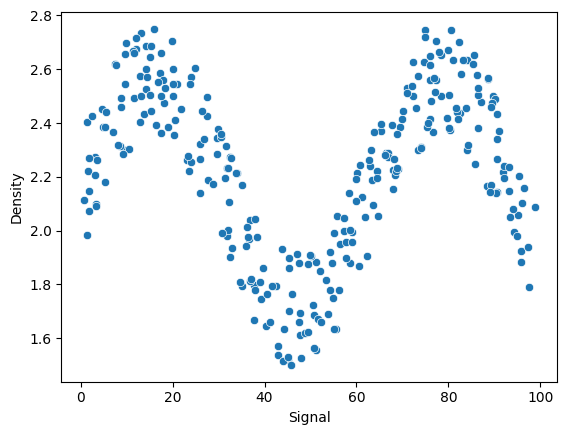

In [48]:
sns.scatterplot(x='Signal', y='Density', data=df)

Мы видим график в виде синусоиды. Сможем ли мы применить тут линейную регрессию?

Если мы работаем только с одним признаком, то для линейной регрессии требуется переформировать объект series  в двумерный массив. Признак по строке (1, -1) или по столбцу (-1, 1)

In [49]:
X = df['Signal'].values.reshape(-1, 1)
y = df['Density']

1. Линейная регрессия

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

Поскольку у нас всего 1 признак, мы не будем проводить масштабирование или стандартизацию.

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
lr_model = LinearRegression()

In [54]:
lr_model.fit(X_train, y_train)

LinearRegression()

Запустим модель на тестовых данных

In [55]:
lr_preds = lr_model.predict(X_test)

In [56]:
lr_preds

array([2.22029657, 2.22047771, 2.22035637, 2.22034337, 2.22039737,
       2.22050555, 2.22042659, 2.22028877, 2.22034673, 2.22029714,
       2.22041506, 2.22050153, 2.22043891, 2.22042003, 2.22047022,
       2.22032403, 2.22033377, 2.22030628, 2.22035154, 2.22035373,
       2.22029266, 2.22036798, 2.22033018, 2.22030611, 2.22042754,
       2.22044019, 2.2204142 , 2.22040303, 2.22048946, 2.22047495])

Судя по данным мы получили практическую горизонтальную линию паралельно оси Х.

Вычислим метрики

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [58]:
mean_absolute_error(y_test, lr_preds)

np.float64(0.211198973318633)

Отклонение на 10%

In [59]:
np.sqrt(mean_squared_error(y_test, lr_preds))

np.float64(0.2570051996584629)

Получаем похожее значение. 

Можно предположить, что модель работает не плохо. Построим график диапазоне от 0 до 100 nHz). 

In [60]:
signal_range = np.arange(0, 100)

In [61]:
signal_preds = lr_model.predict(signal_range.reshape(-1, 1))

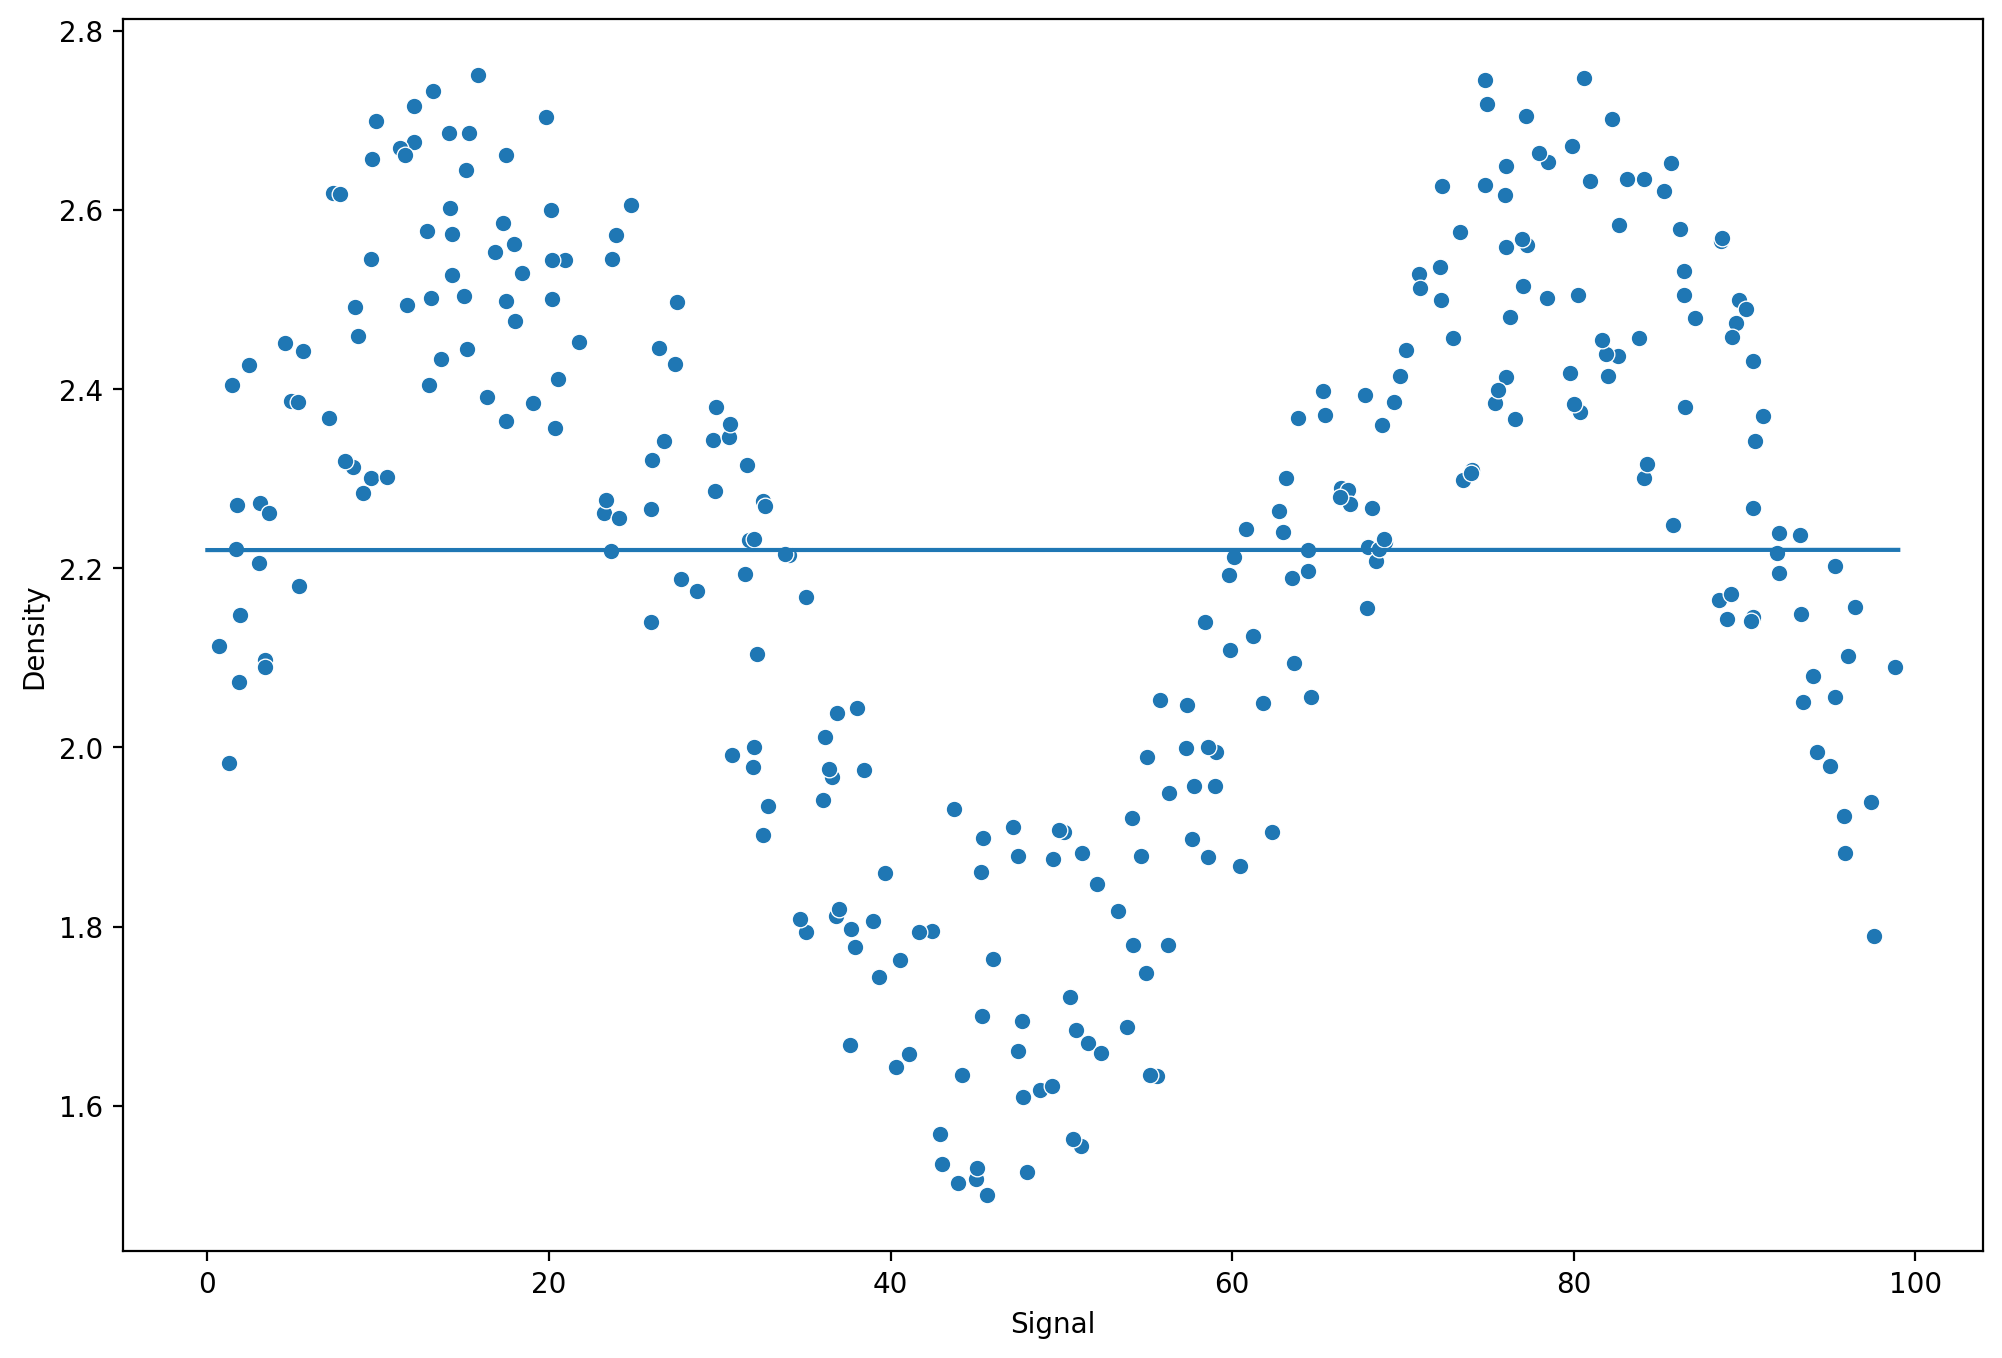

In [62]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(x='Signal', y='Density', data=df)

plt.plot(signal_range, signal_preds)

Несмотря на не плохие метрики мы видим, что линейная регрессия не справляется с этой задачей. 

2. Полиномиальная регрессия

Напишем вспомогательную функцию для разных типов моделей.

In [63]:
def run_model(model, X_train, y_train, X_test, y_test):
    # обучим модель
    model.fit(X_train, y_train)

    # вычислим метрики
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    # построим график с результатами
    signal_range = np.arange(0, 100)
    signal_preds = model.predict(signal_range.reshape(-1, 1))

    plt.figure(figsize=(12, 8), dpi=200)
    sns.scatterplot(x='Signal', y='Density', data=df, color='black')

    plt.plot(signal_range, signal_preds)

Посмотрим как работает функция на линейной регрессии

MAE: 0.211198973318633
RMSE: 0.2570051996584629


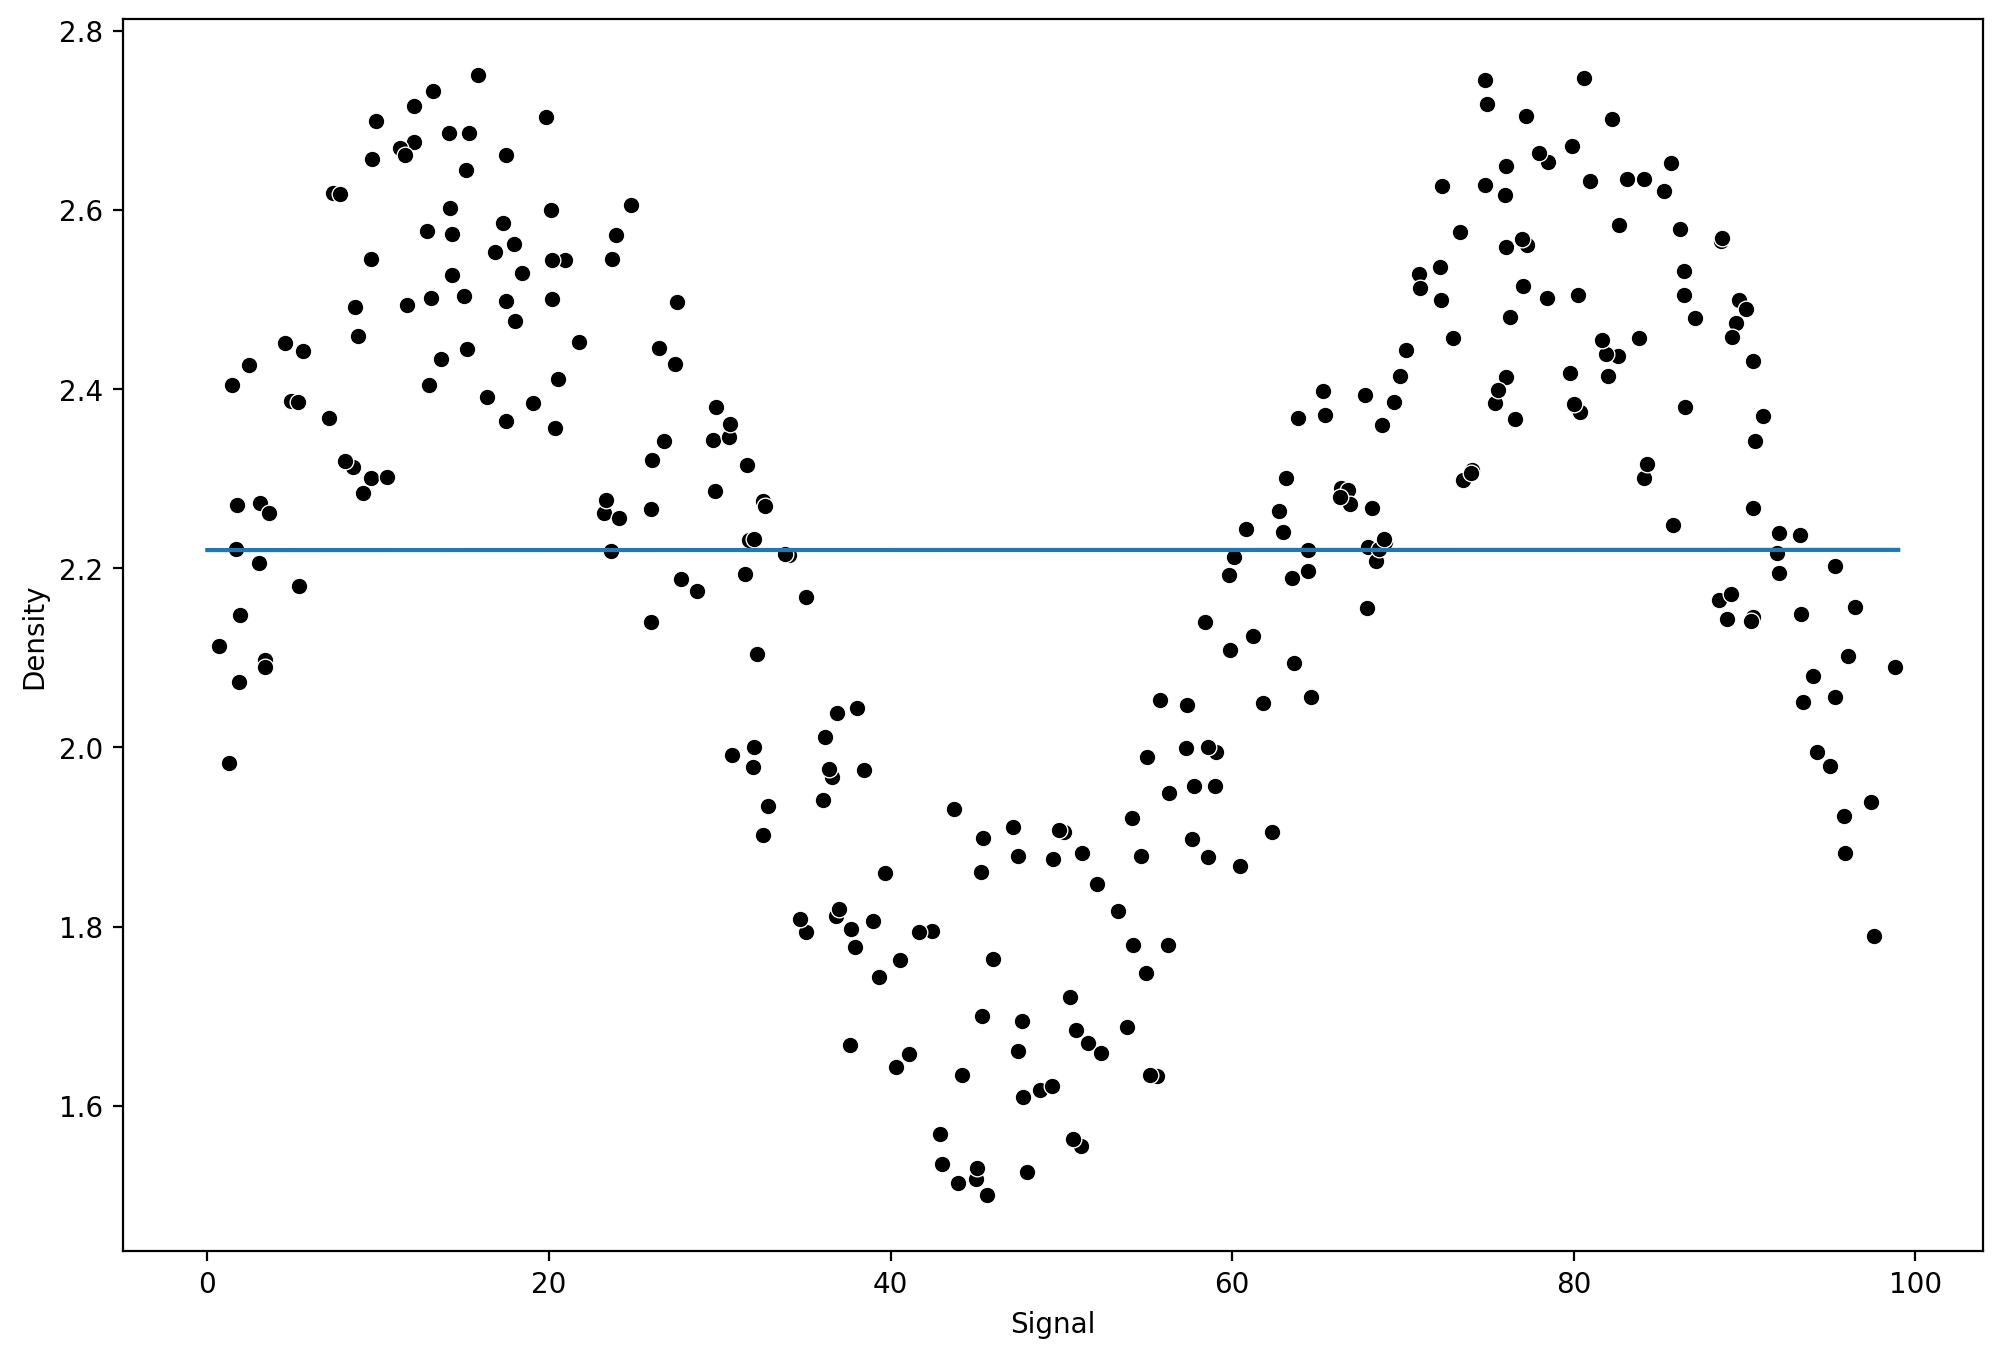

In [64]:
model = LinearRegression()
run_model(model, X_train, y_train, X_test, y_test)

Создадим полиномиальные признаки для модели

In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [66]:
pipe = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

Мы создали модель. Запустим её в нашей функции.

MAE: 0.22903105443511335
RMSE: 0.2817309563725596


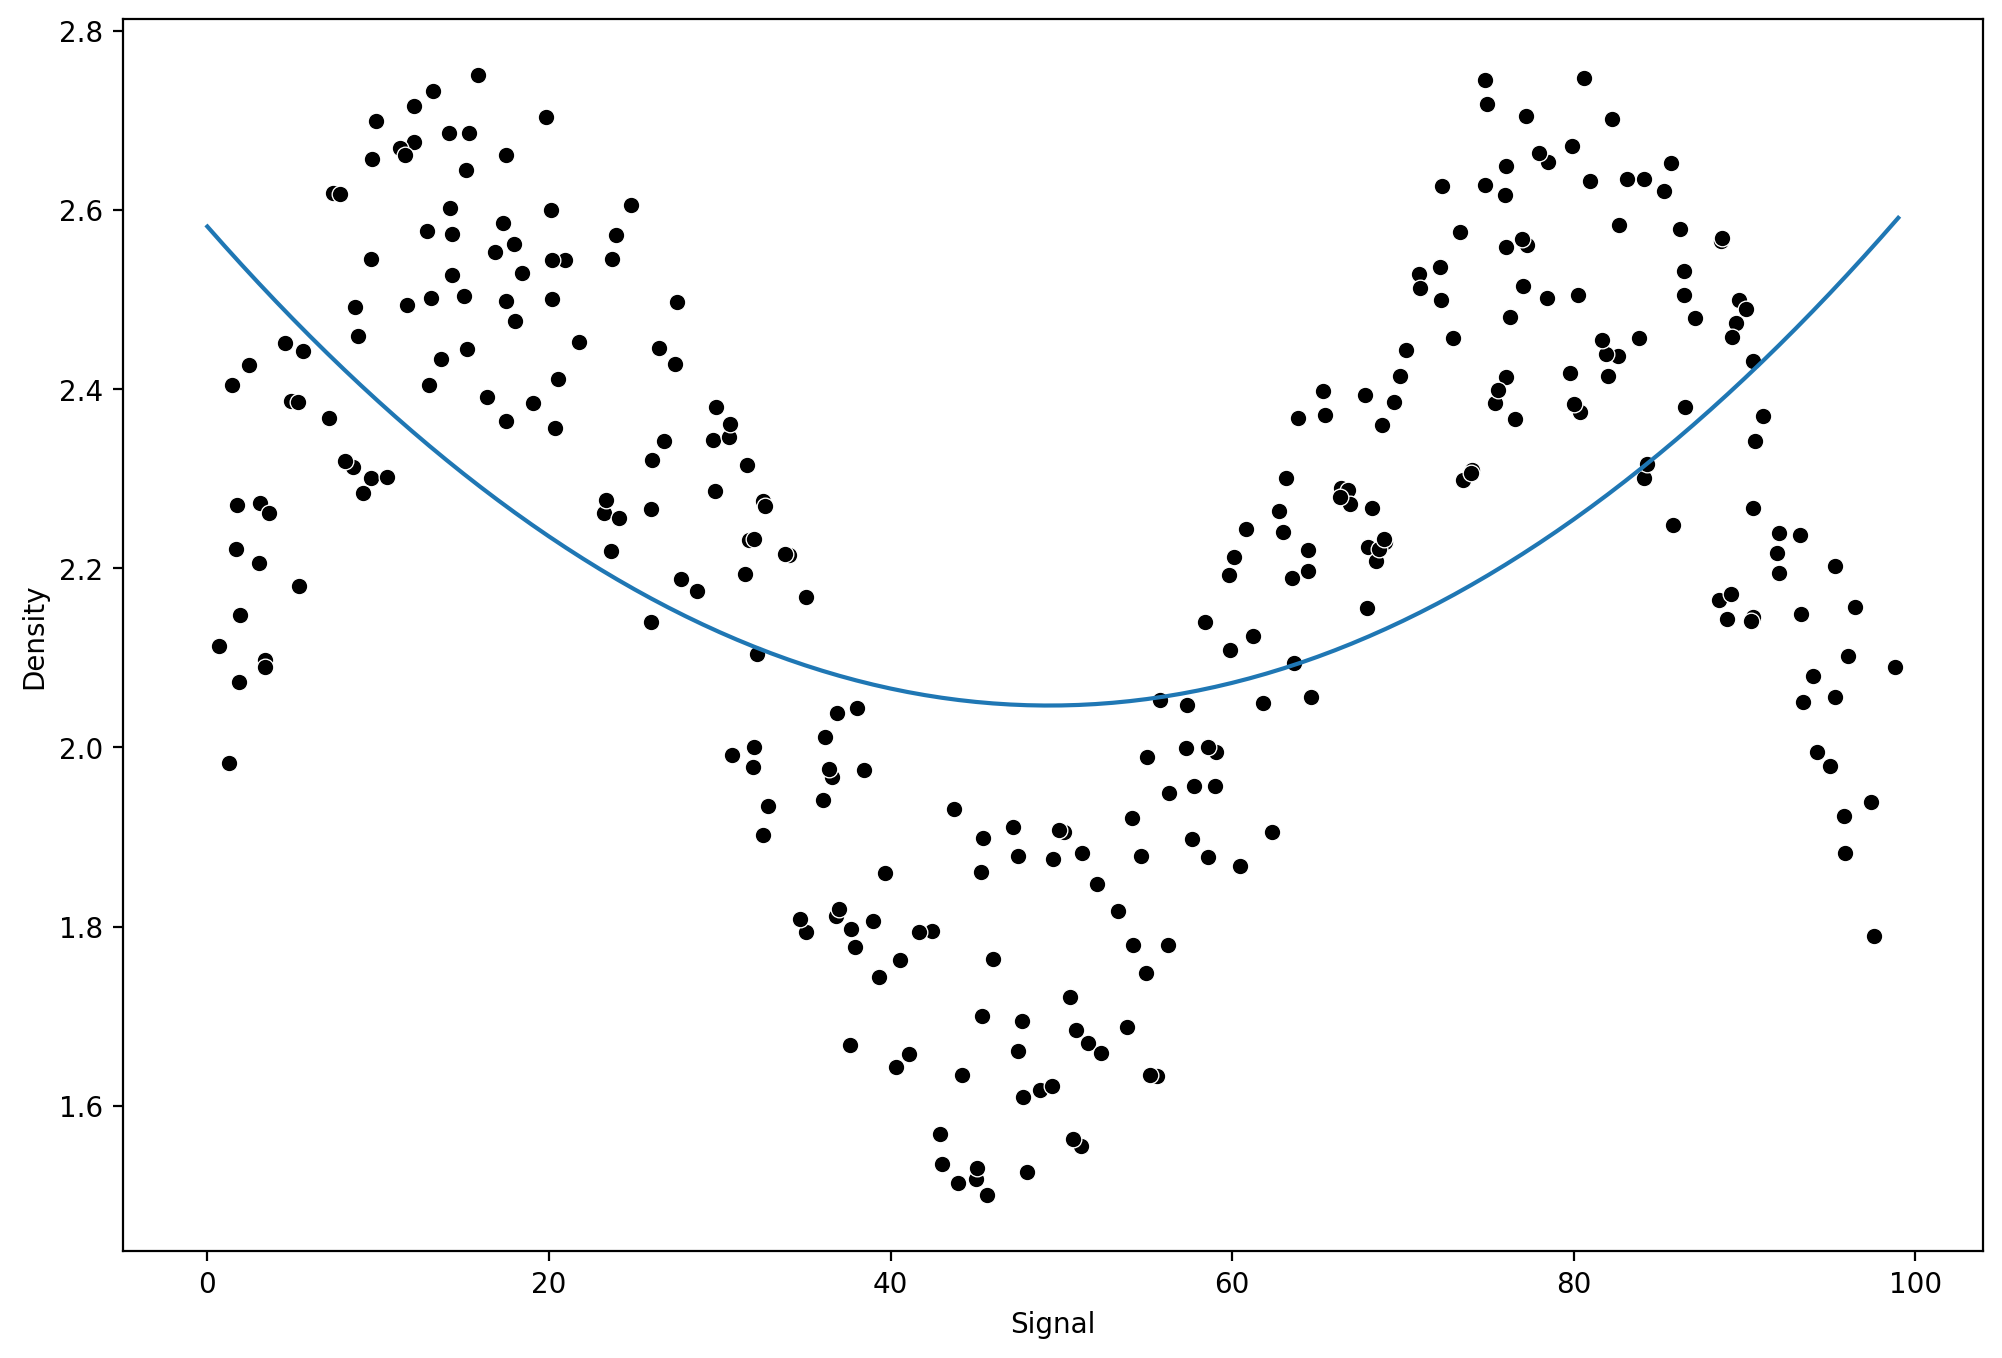

In [67]:
run_model(pipe, X_train, y_train, X_test, y_test)

Мы получили схожие метрики и неработающую модель.

Увеличим степень полинома с 2 до 6.

In [68]:
pipe = make_pipeline(PolynomialFeatures(degree=6), LinearRegression())

MAE: 0.11969168049270058
RMSE: 0.13807520083403252


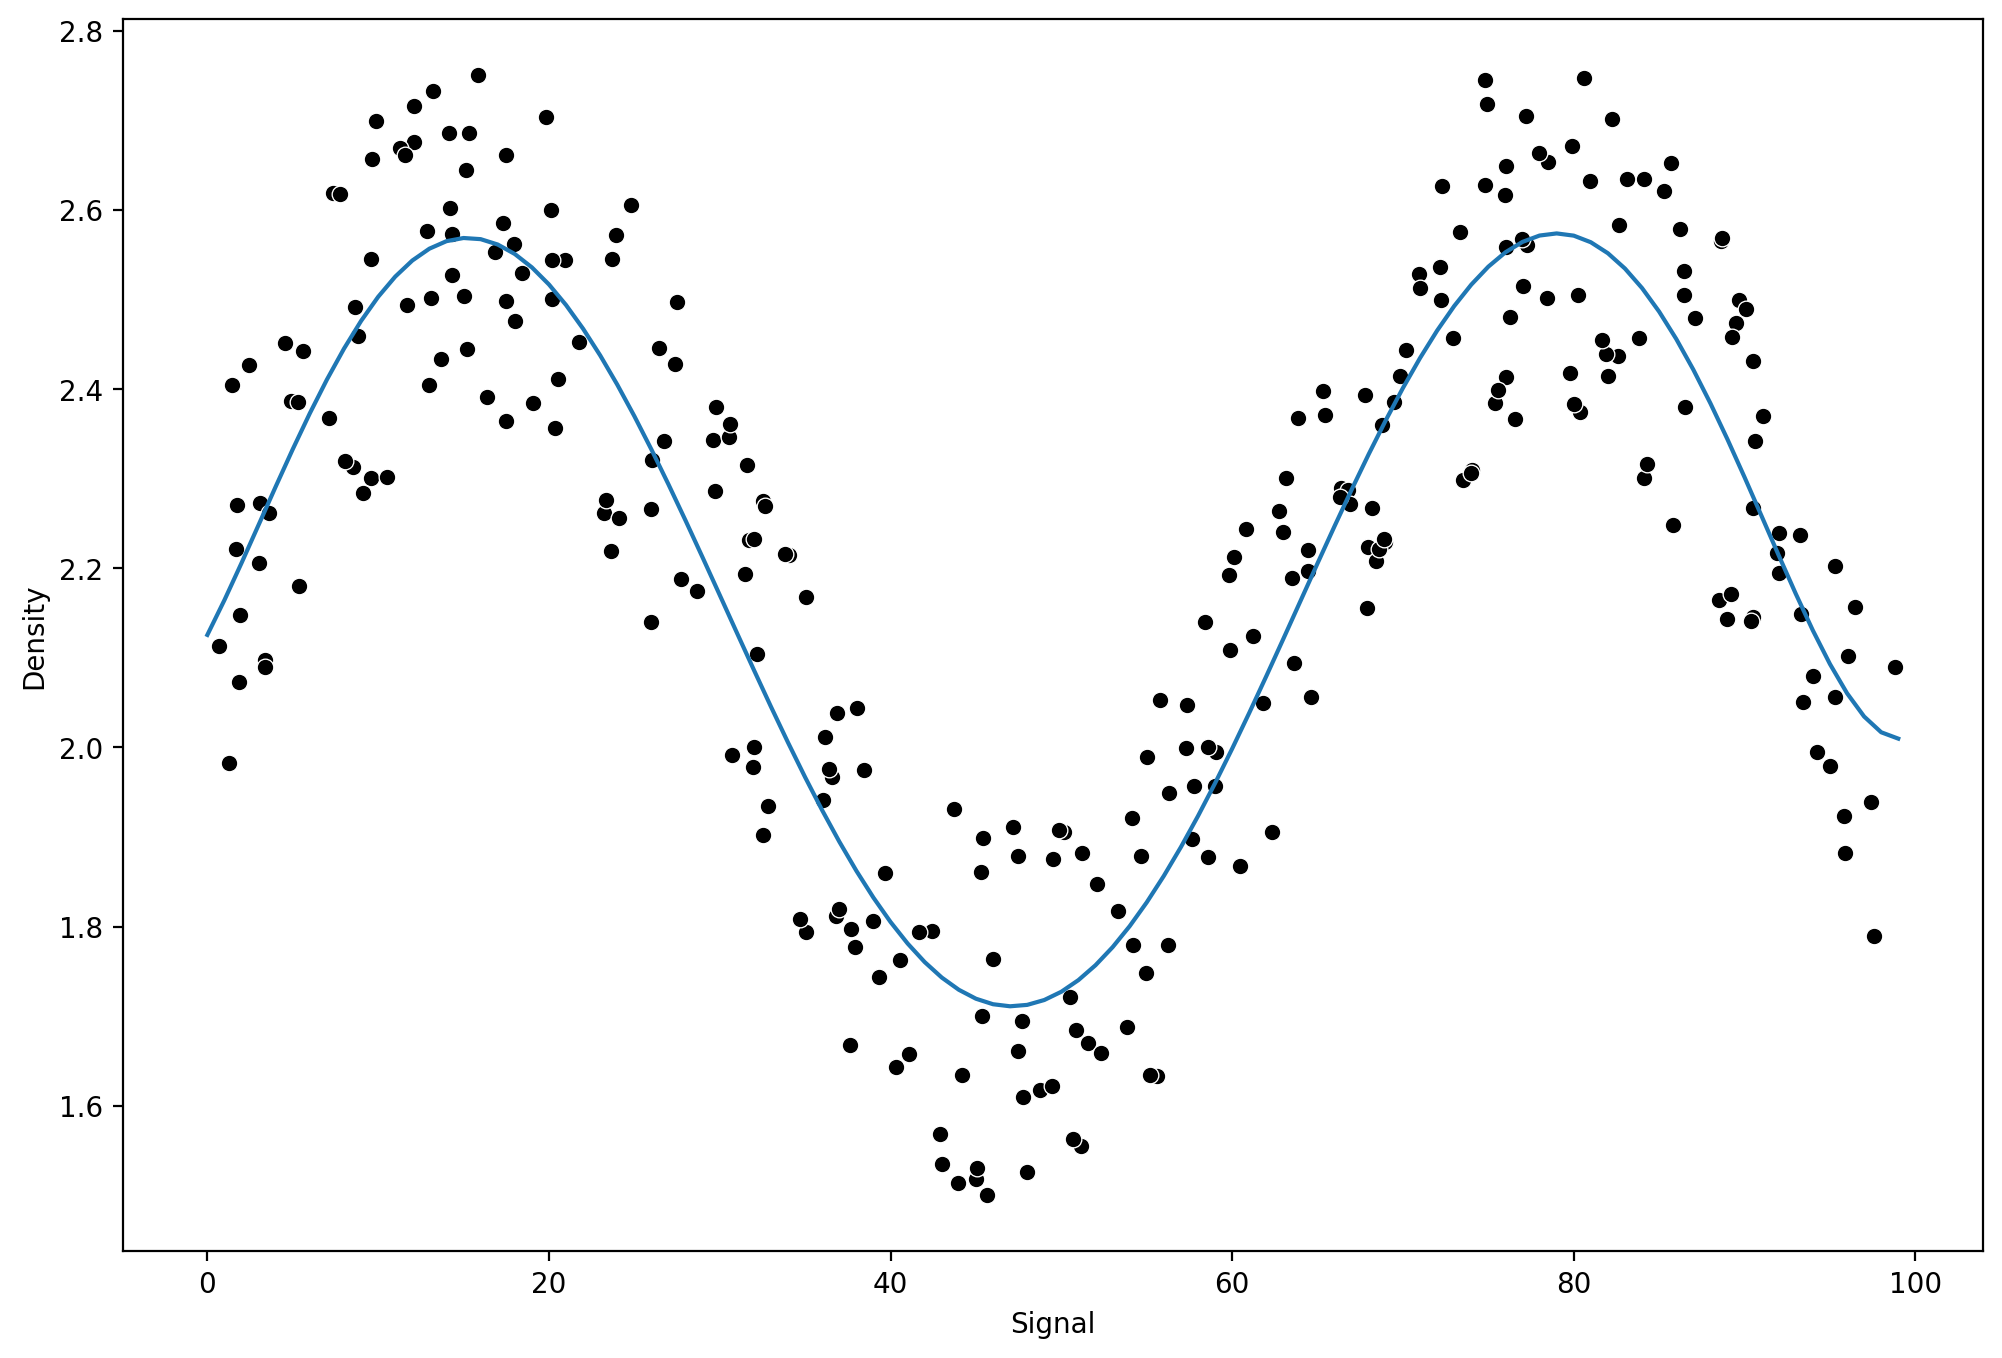

In [69]:
run_model(pipe, X_train, y_train, X_test, y_test)

Мы получили неплохой график и метрики. Но в данной случае мы рискуем попасть на переобученность модели, когда наша полиномиальная модель слишком хорошо знает все шумы в данных. Нужно подобирать степень полинома и смотреть график. Тут я оставил лишь два варианта - 2 и 6, но перебрал их от 2 до 15. И полином в степени 6 показывает хороший результат, а переобучаться начинает ближе к значению 9. 

Для такого результата необходимо знать диапазон значений, у нас он от 0 до 100 nHz (signal_range). В таком случае мы можем сделать вывод о том, что полиномиальныа регрессия может справиться с задачей, но линейная регрессия - нет. 

3. Регрессия KNN

In [70]:
from sklearn.neighbors import KNeighborsRegressor

Напишем цикл, чтобы узнать, сколько ближайших соседей нам лучше взять для решения данной задачи.

MAE: 0.11877297474442378
RMSE: 0.1523487028635337
MAE: 0.12198383614100558
RMSE: 0.13730685016923647
MAE: 0.11635971693292672
RMSE: 0.13277855732740926
MAE: 0.13363165935705318
RMSE: 0.15954234753677107


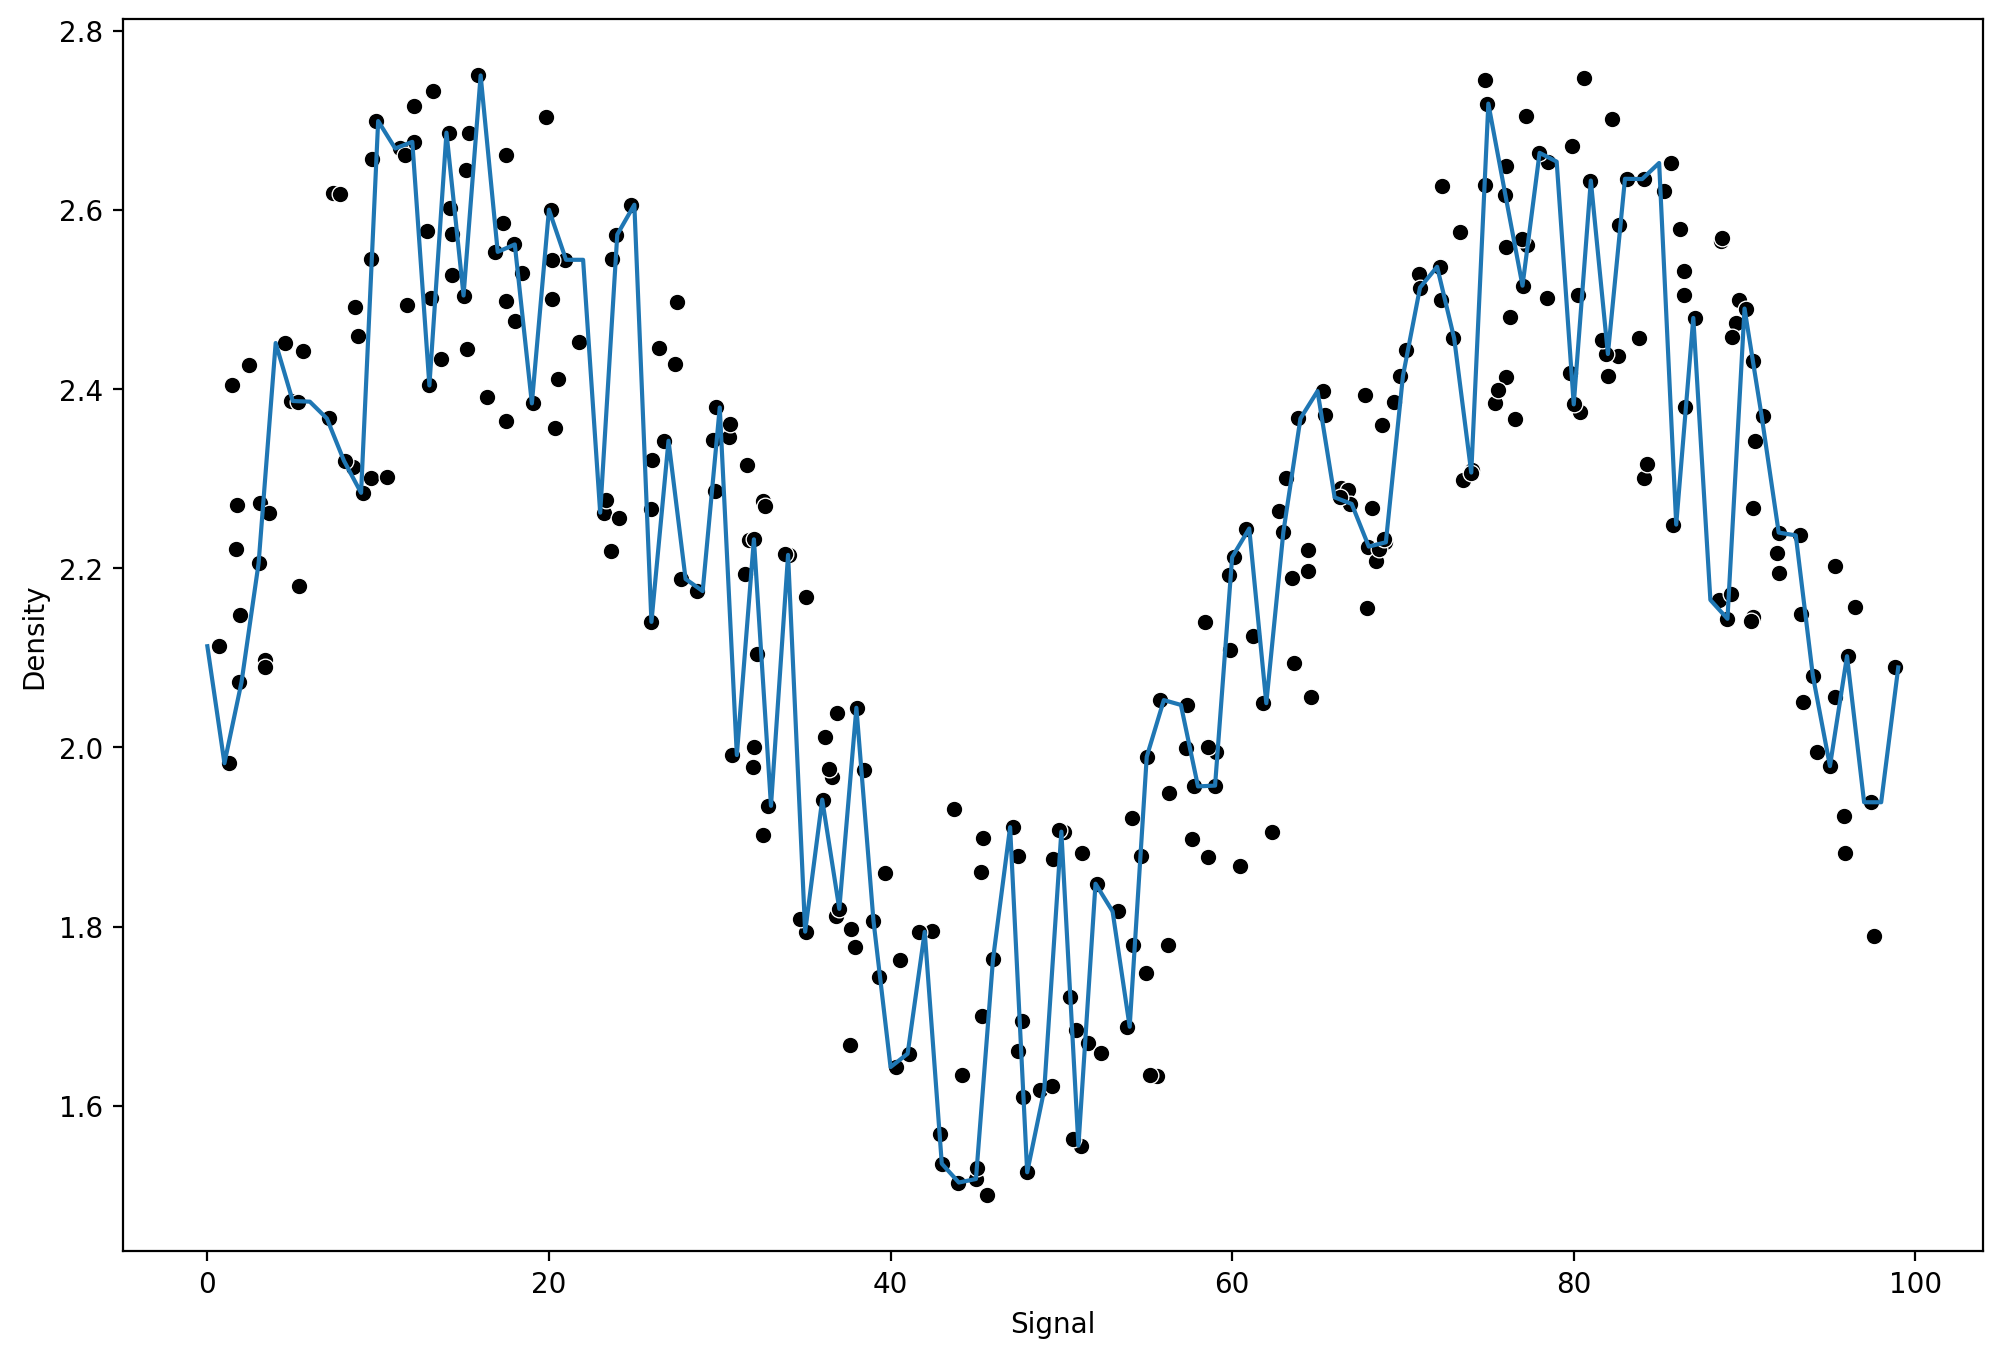

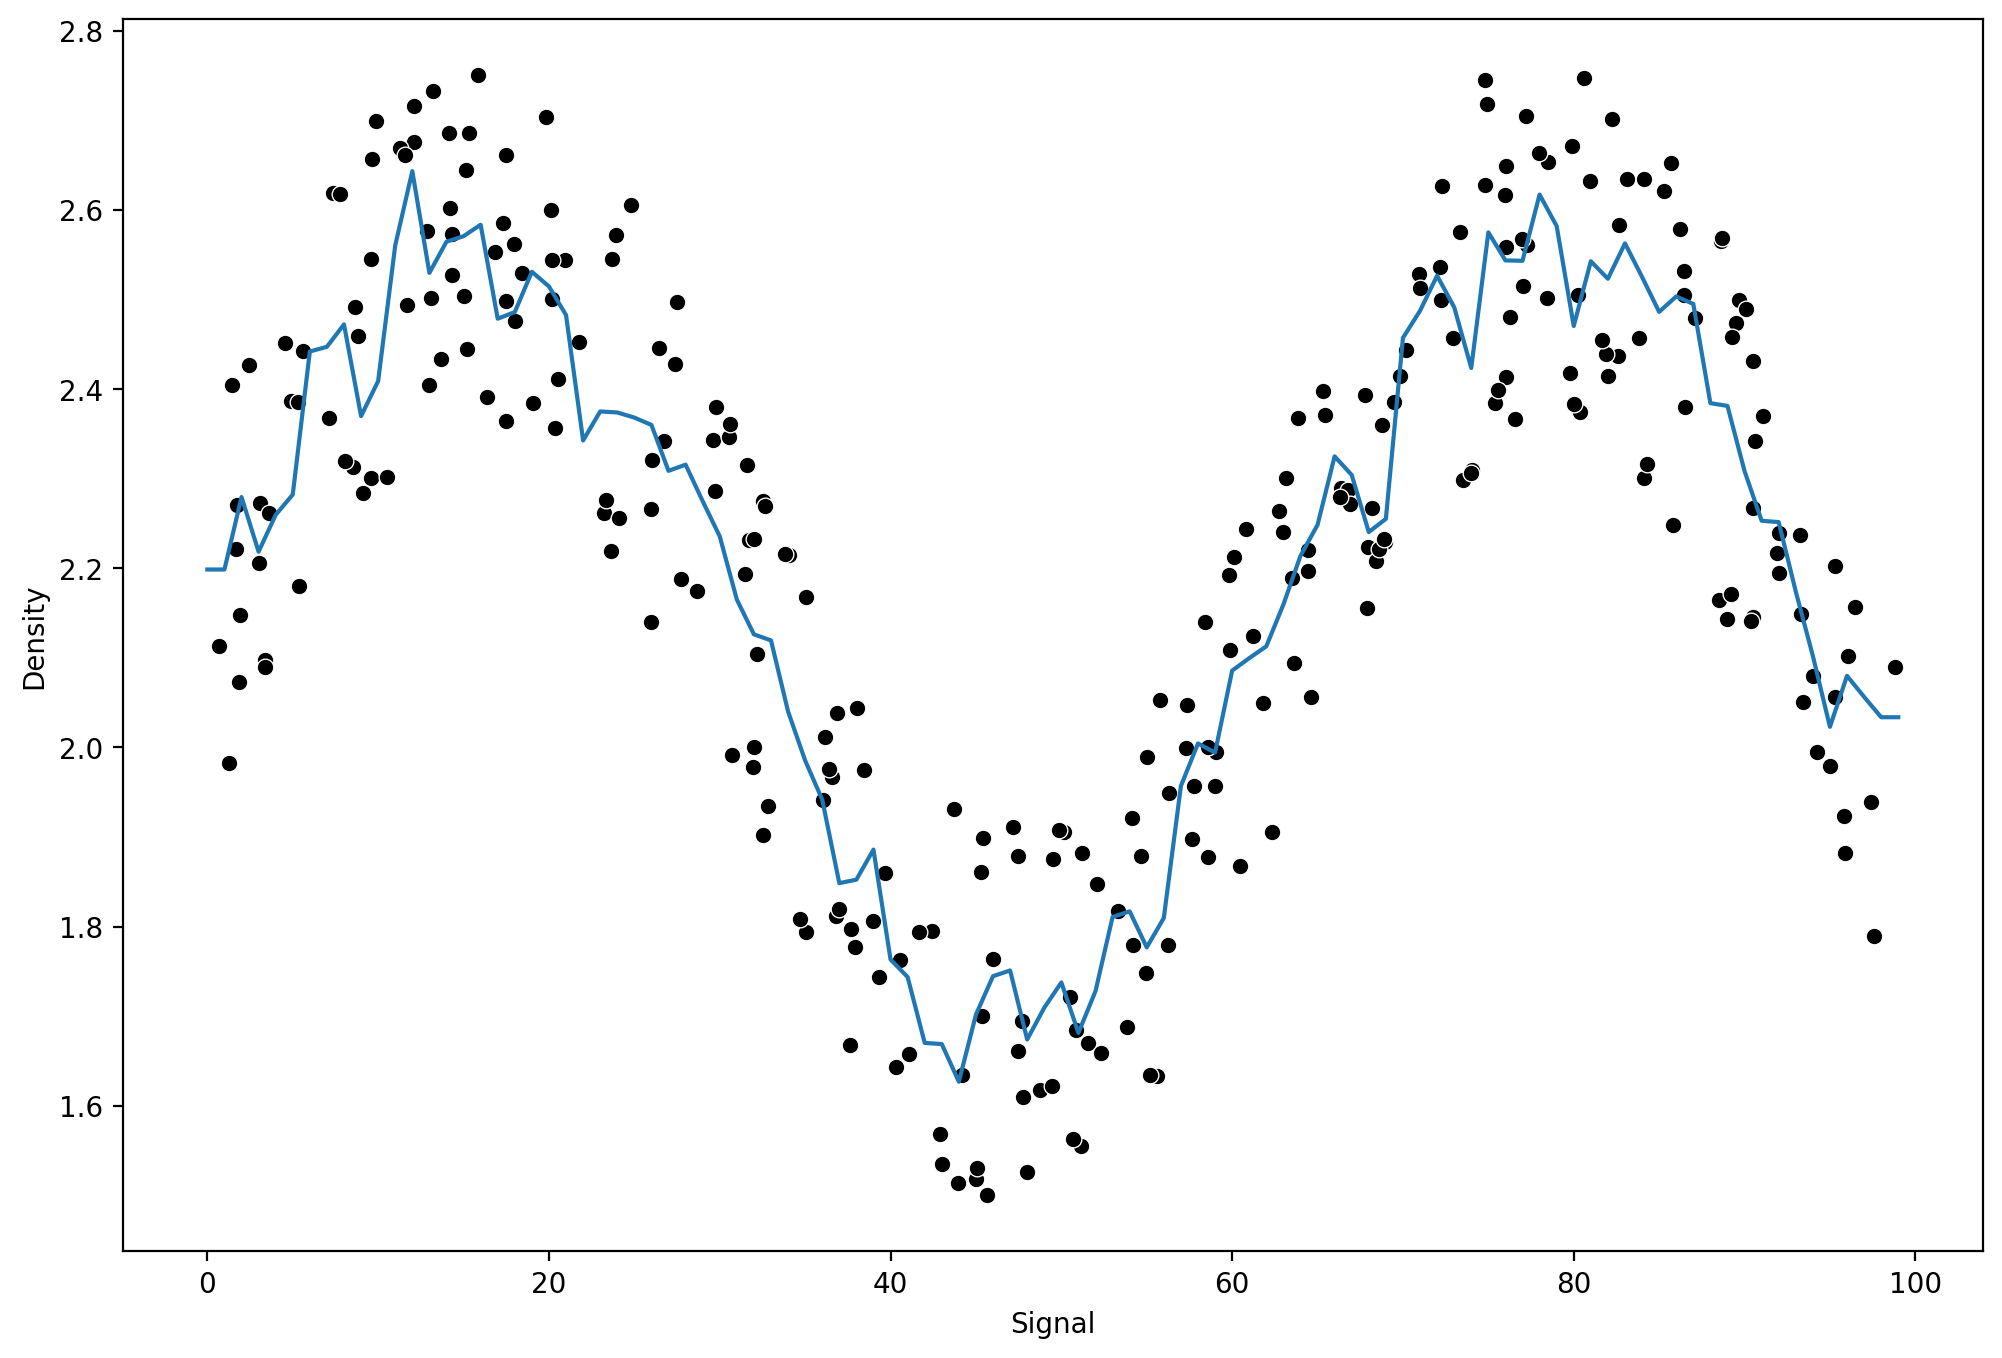

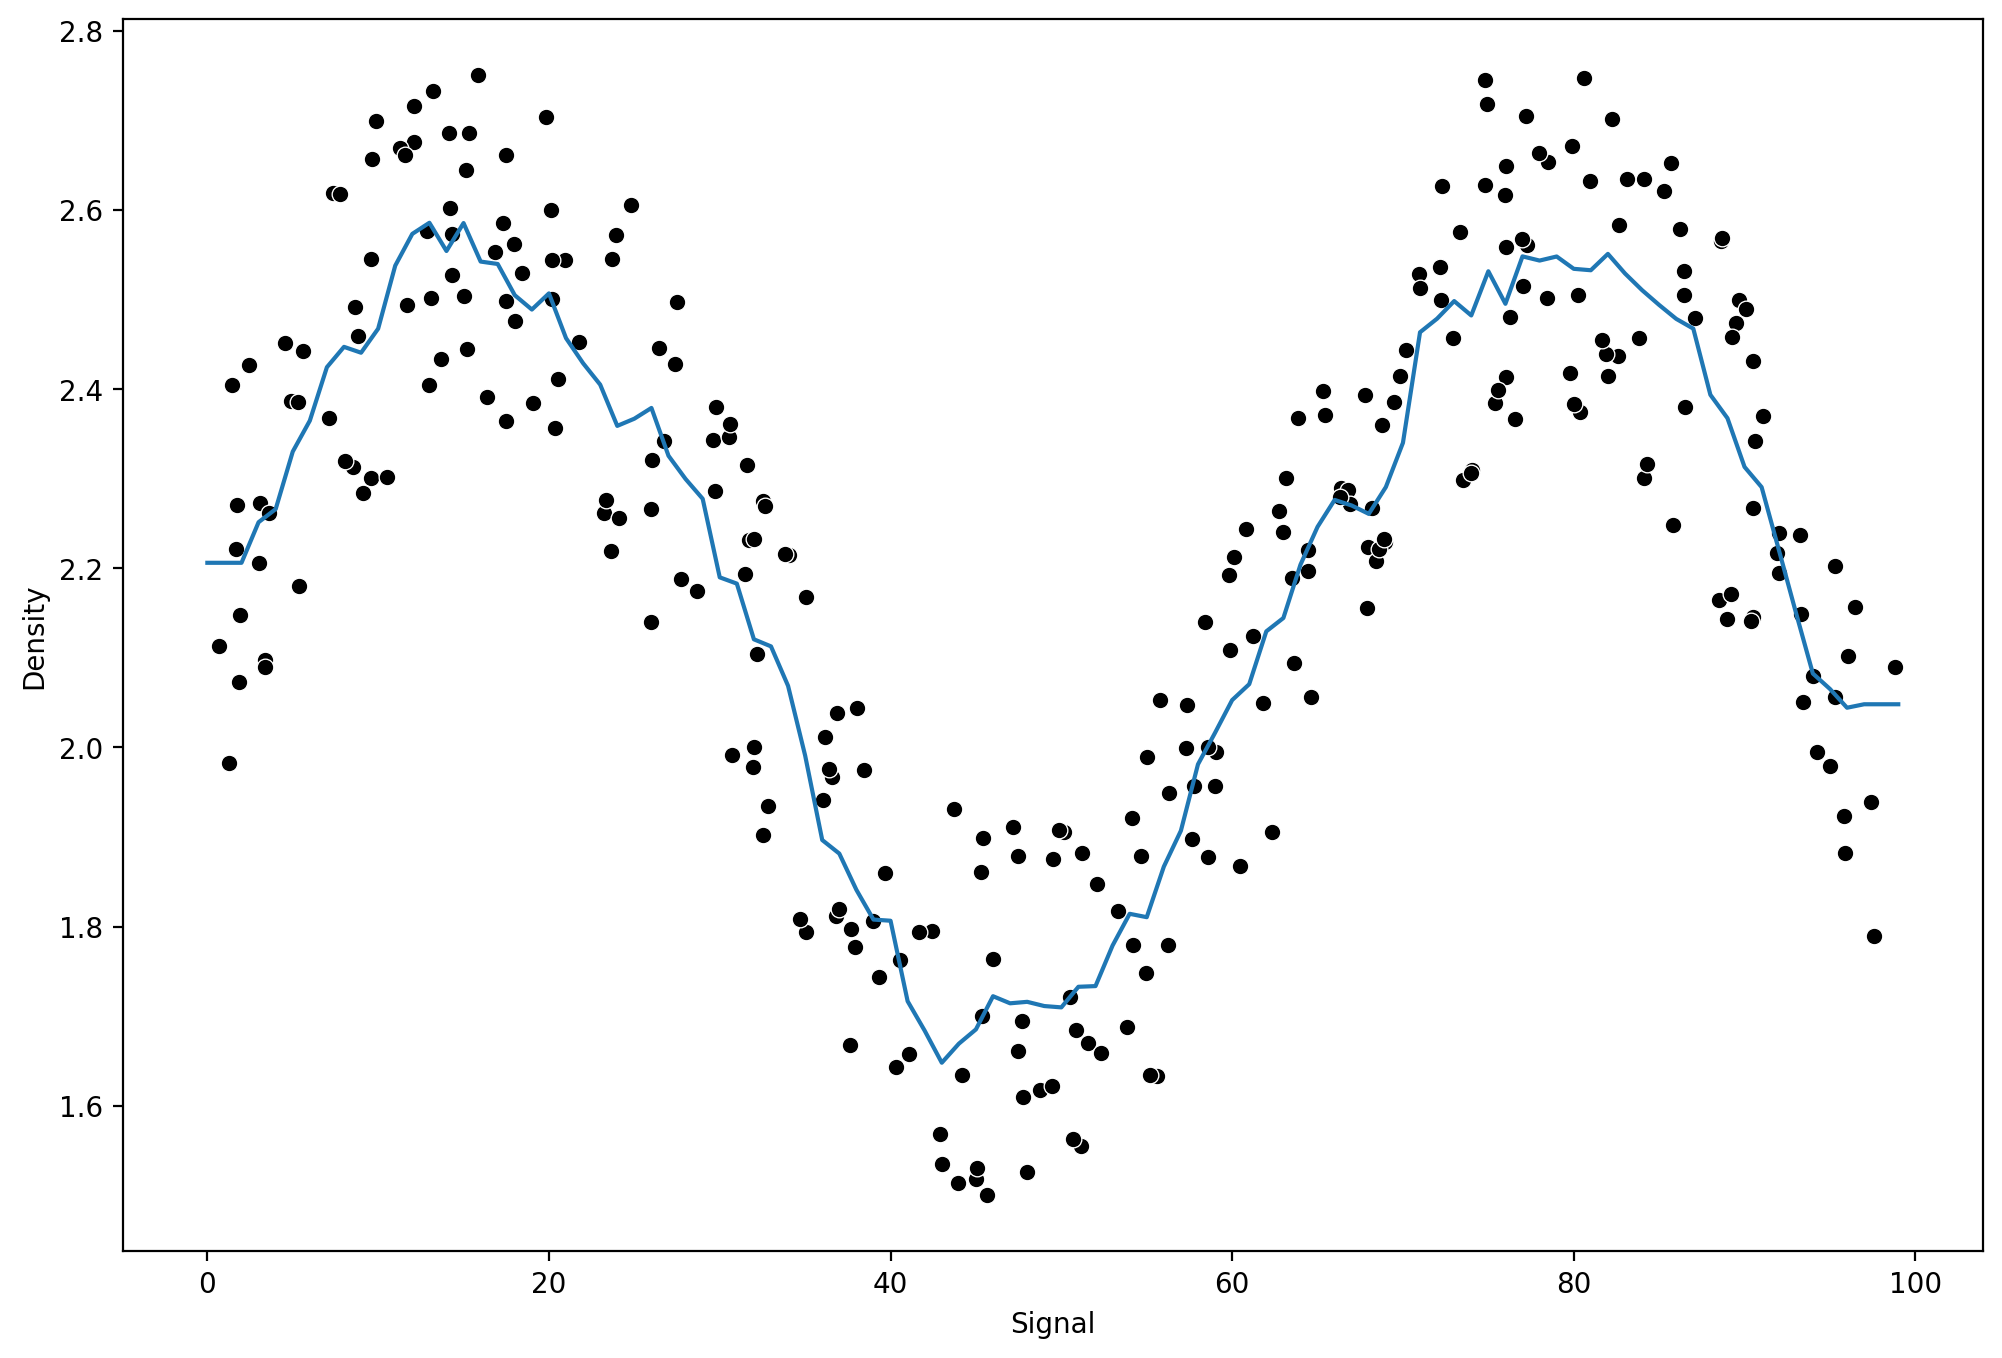

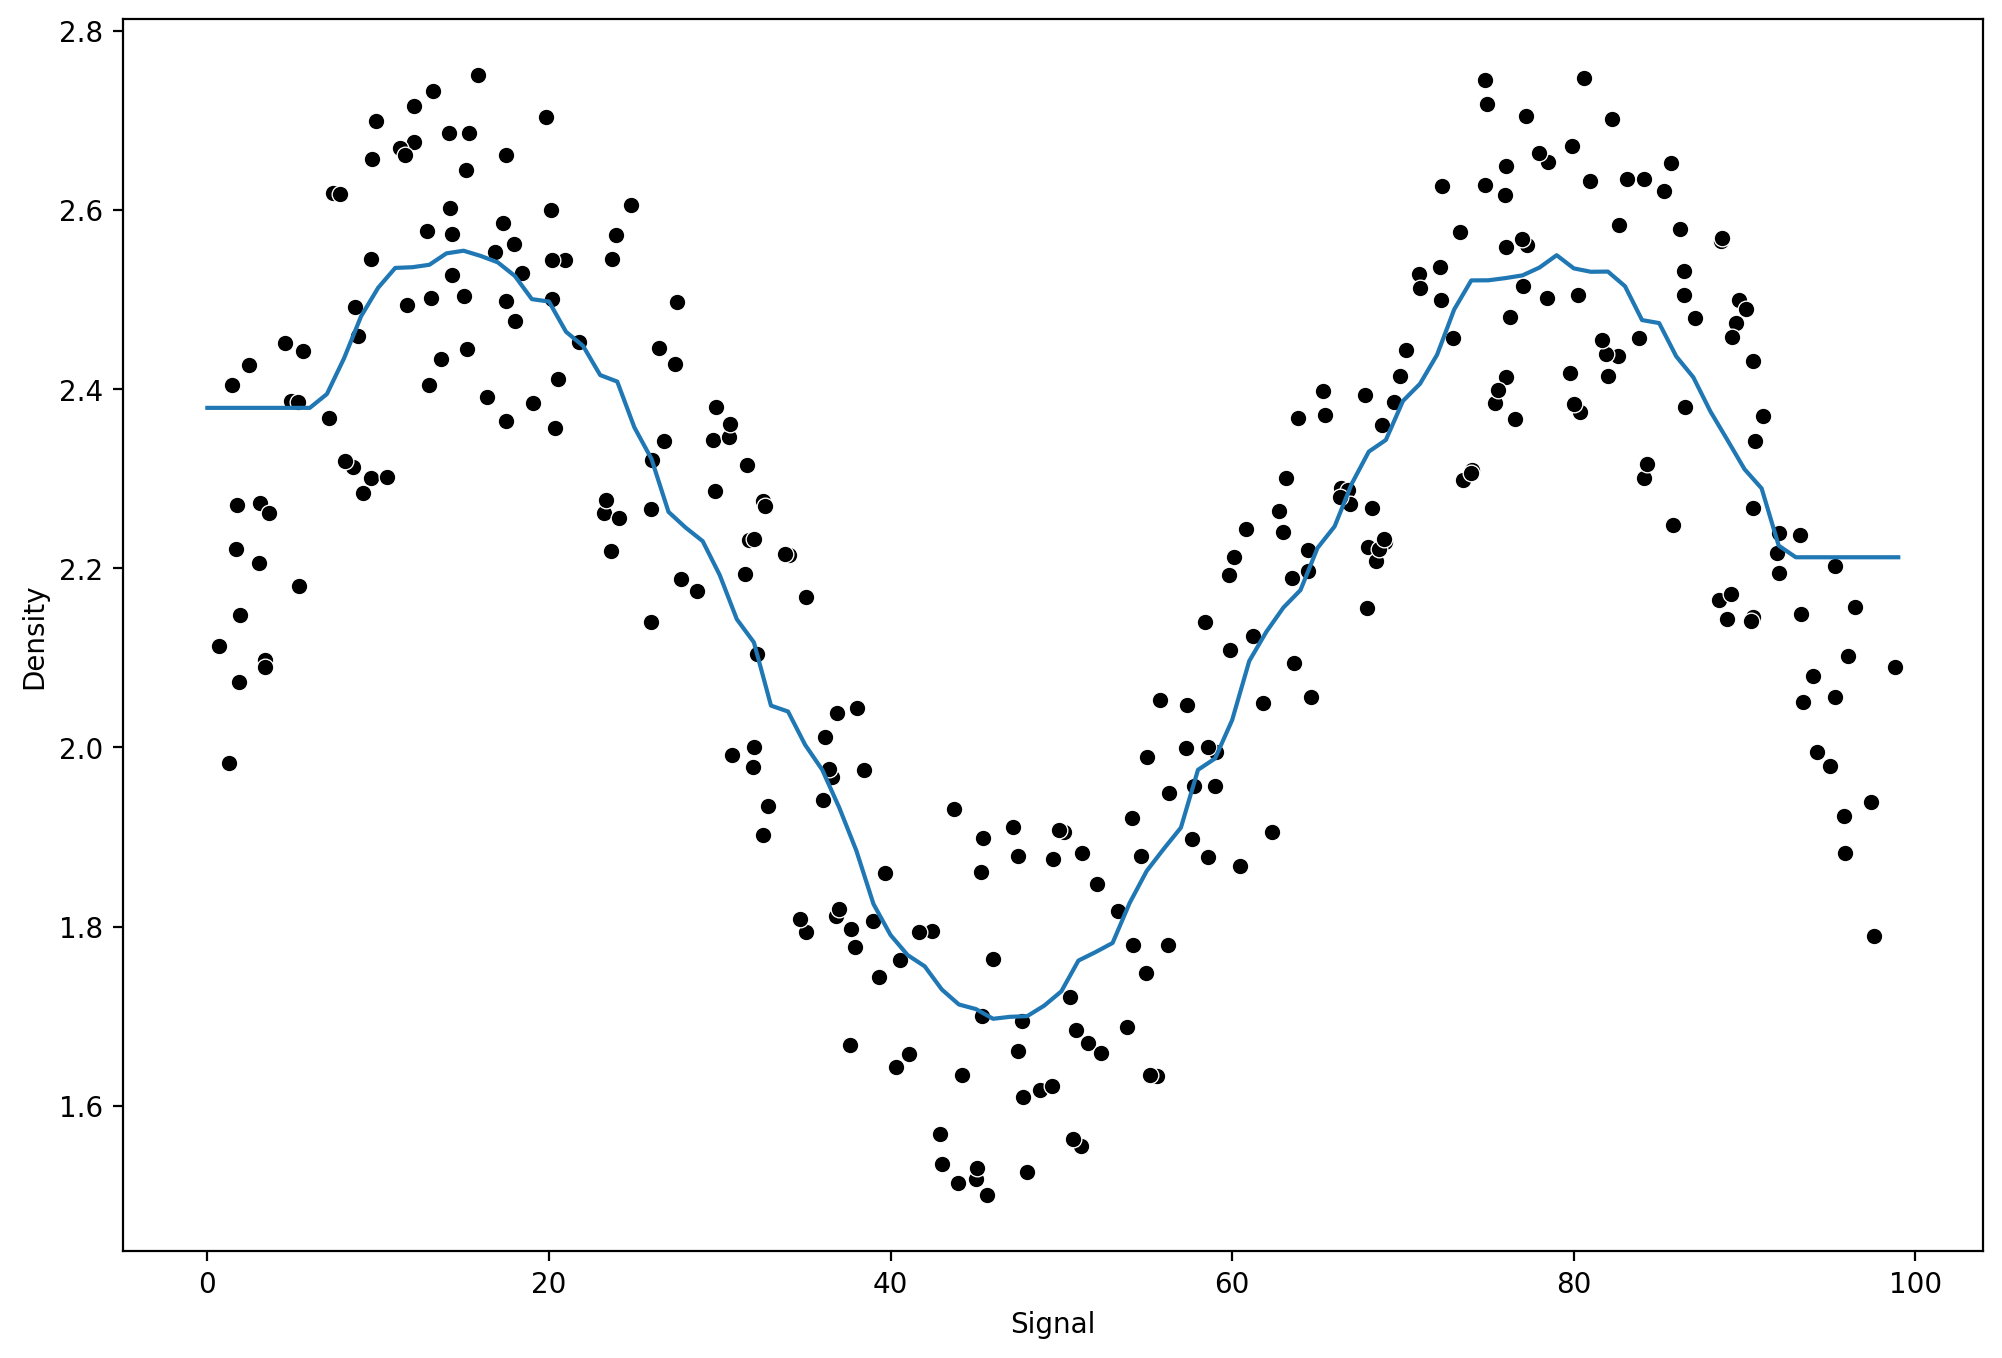

In [71]:
# Укажем значения к, которые мы будем проверять
k_values = [1, 5, 10, 30]

for n in k_values:
    # создадим модель и переберем значения соседей n_neighbors
    knn = KNeighborsRegressor(n_neighbors=n)  # возьмем 1, 5 и 10 соседей = k_values

    # сразу запустим ближайших соседей через нашу функцию
    run_model(knn, X_train, y_train, X_test, y_test)

Мы получили графики для к=1, к=5 и к=10.

- На первом графике к=1 мы видим график в виде пилы. Этот метод сильно отвлекается на любые шумы - очень много дисперсий. Но этот график проходит очень близко к большинству точек. 
- При увеличении значения к=5 мы видим более усредненные значения. Мы добавили в модель больше смещения и график получился более плавным.
- При более высоком значении к=10 мы получили еще более плавный график.
- Добавим значение *к=30* и увидим еще более плавный график. При этом на краях диапазона мы получили отрезки прямой линии, что указывает на переобучение. 

4. Регрессия деревьев решений (Decision Trees)

In [72]:
from sklearn.tree import DecisionTreeRegressor

In [73]:
dtr = DecisionTreeRegressor()

MAE: 0.11877297474442378
RMSE: 0.1523487028635337


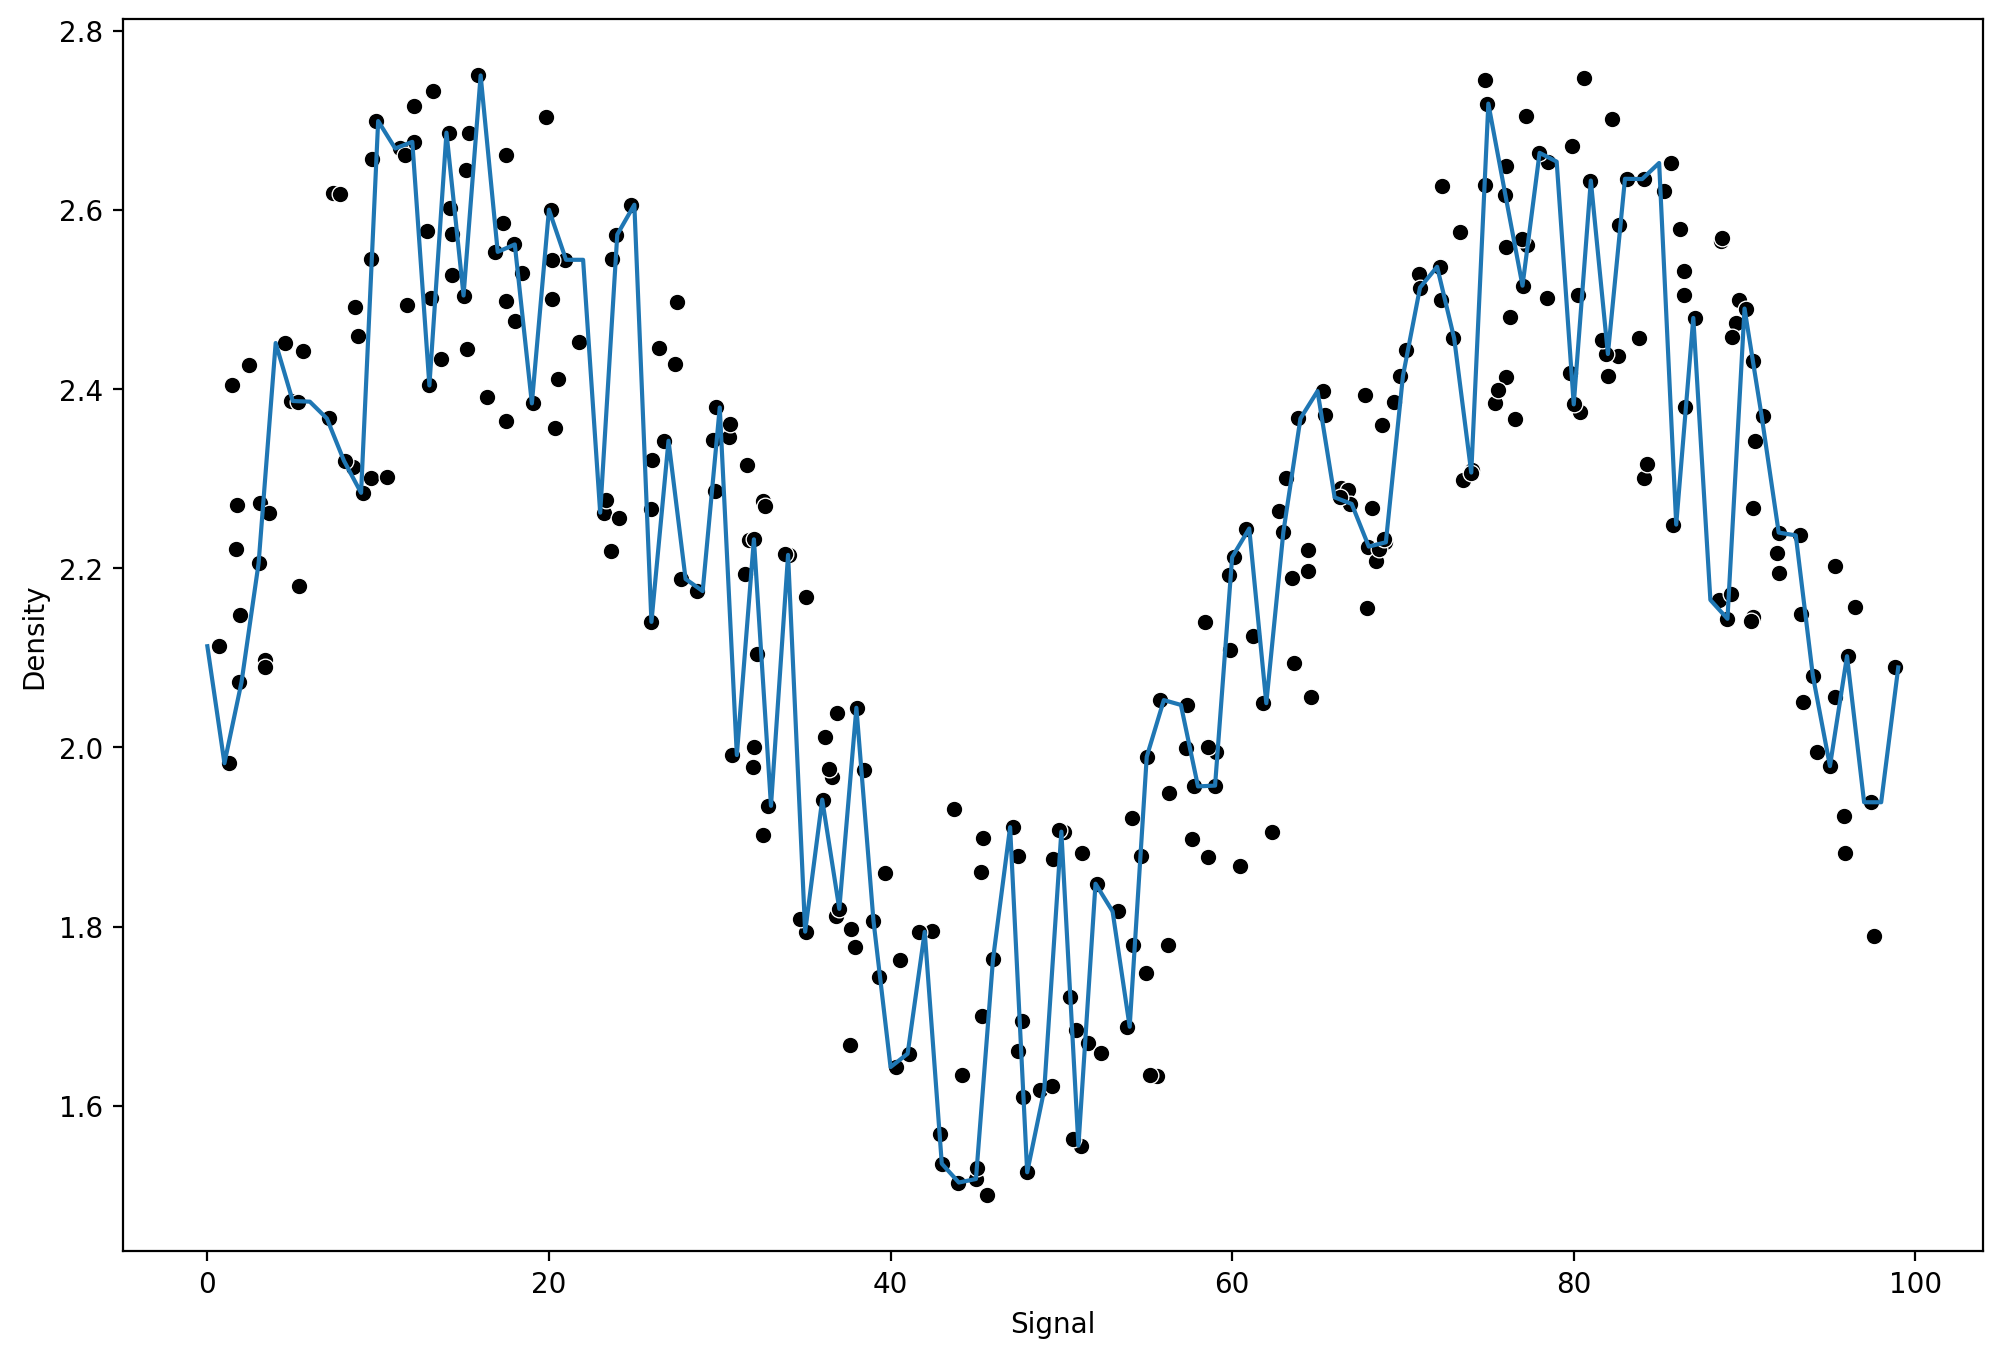

In [74]:
run_model(dtr, X_train, y_train, X_test, y_test)

Мы видим похожий на KNN график, где к=1. 

5. Регрессия методом опорных векторов (CVR)

Для этого метода нам потребуются дополнительные параметры - C и gamma. Они подбираются при помощи кросс-валидации и поиска по сетке.

In [75]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [76]:
svr = SVR()

param_grid = {'C': [0.01, 0.1, 1, 5, 10, 100, 1000],
             'gamma': ['scale', 'auto']}

grid = GridSearchCV(svr, param_grid)

In [88]:
grid.best_params_

{'C': 1000, 'gamma': 'scale'}

Обучим модель svr, подберем гиперпараметры и нарисуем график внутри функции run_model

MAE: 0.10854210121348368
RMSE: 0.12646999302046696


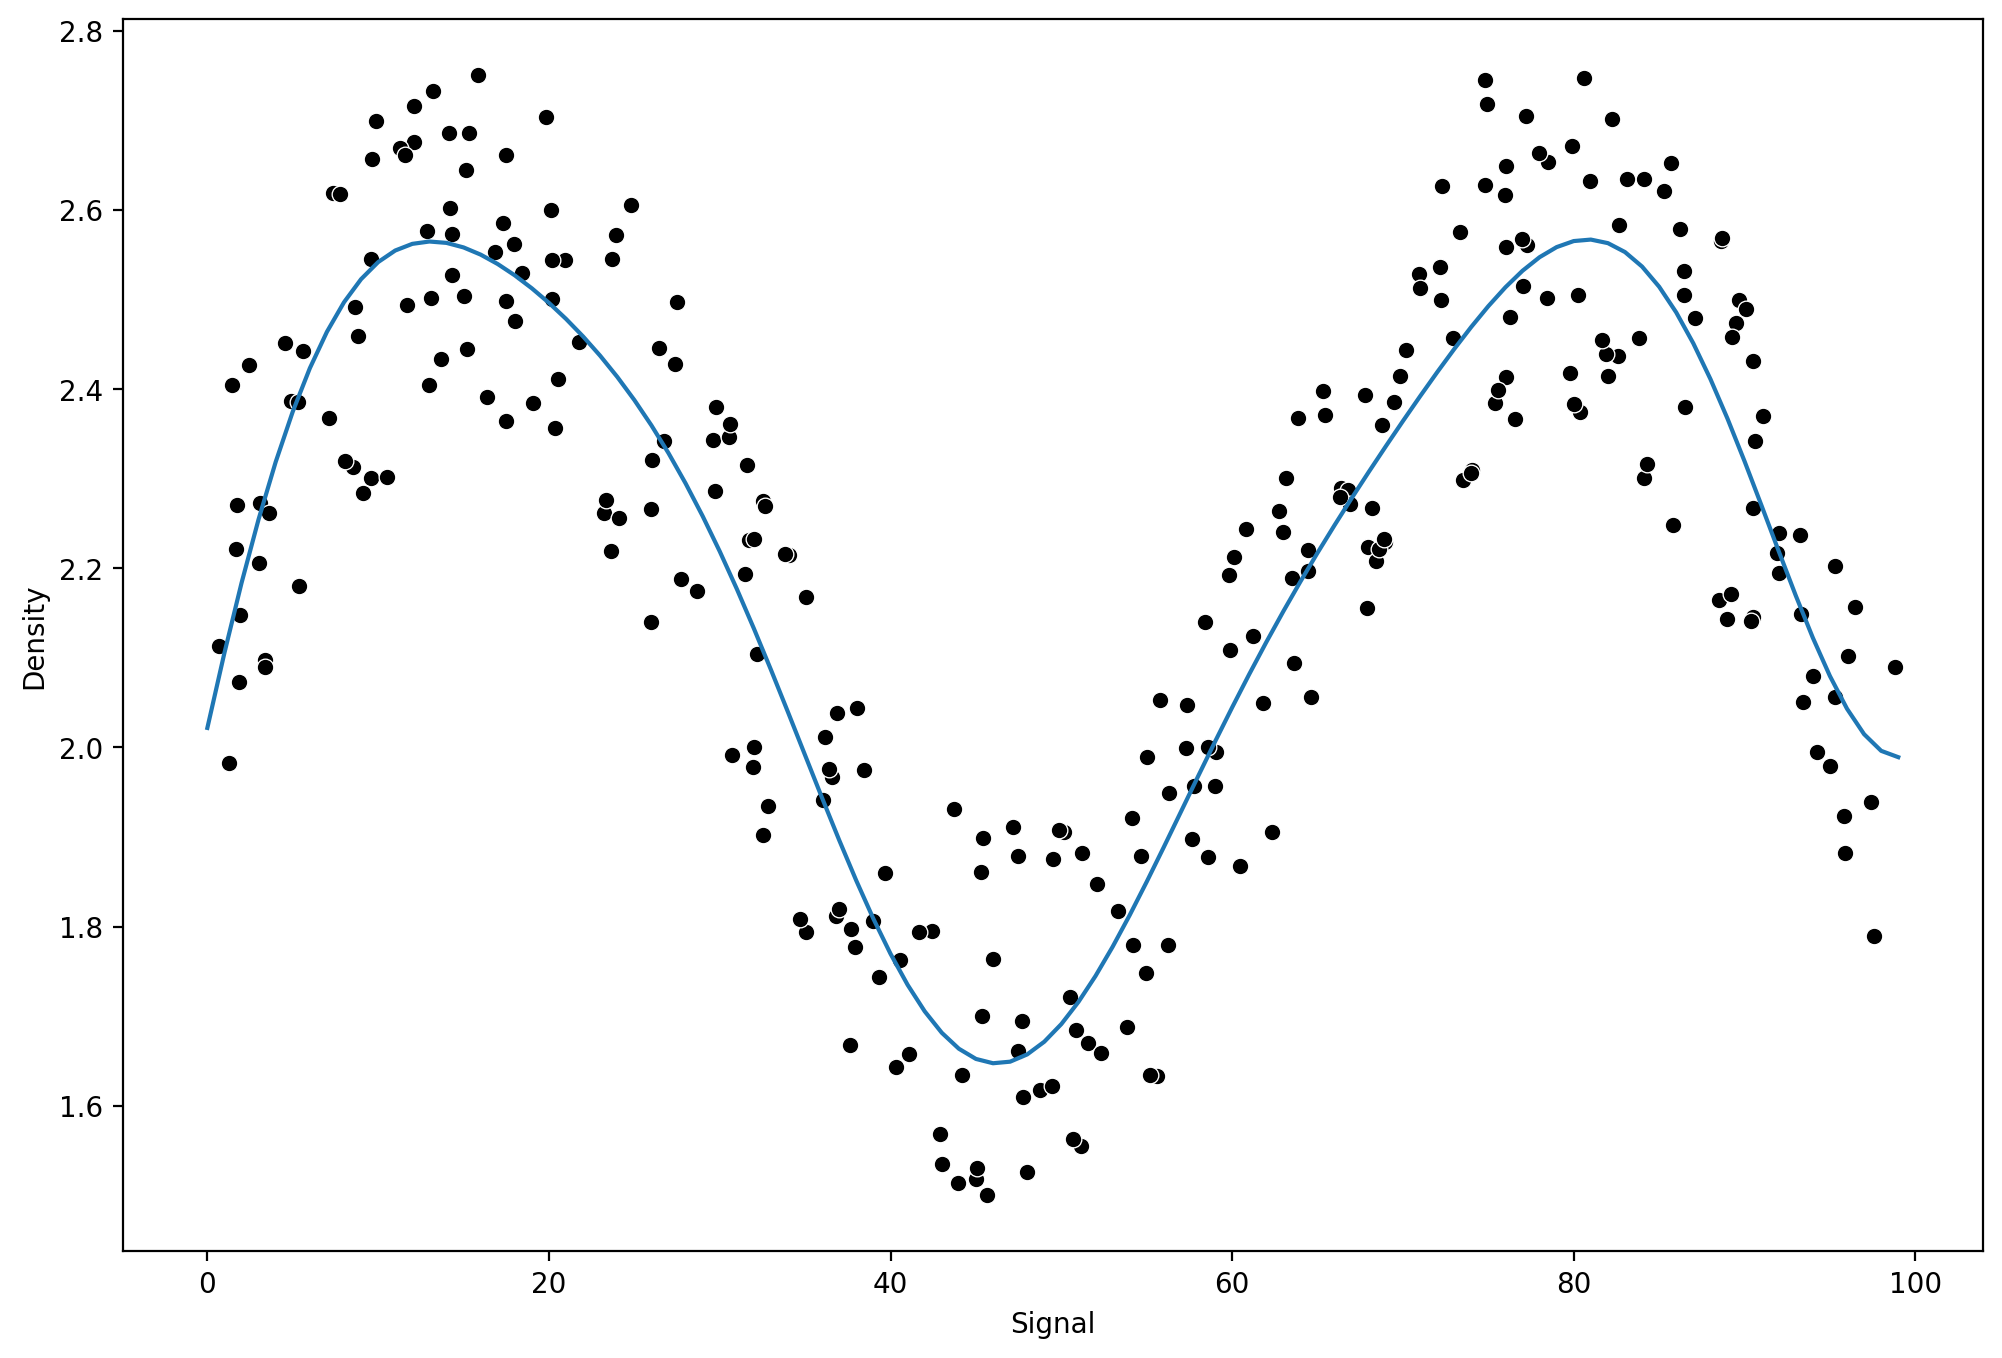

In [77]:
run_model(grid, X_train, y_train, X_test, y_test)

Мы получили хороший плавный график. 

6. Регрессия расширяемых деревьев (boosted trees);
   и
7. Регрессия случайных лесов (Random Forest)

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
rfr = RandomForestRegressor(n_estimators=10)

MAE: 0.11104577567807361
RMSE: 0.13635198765553952


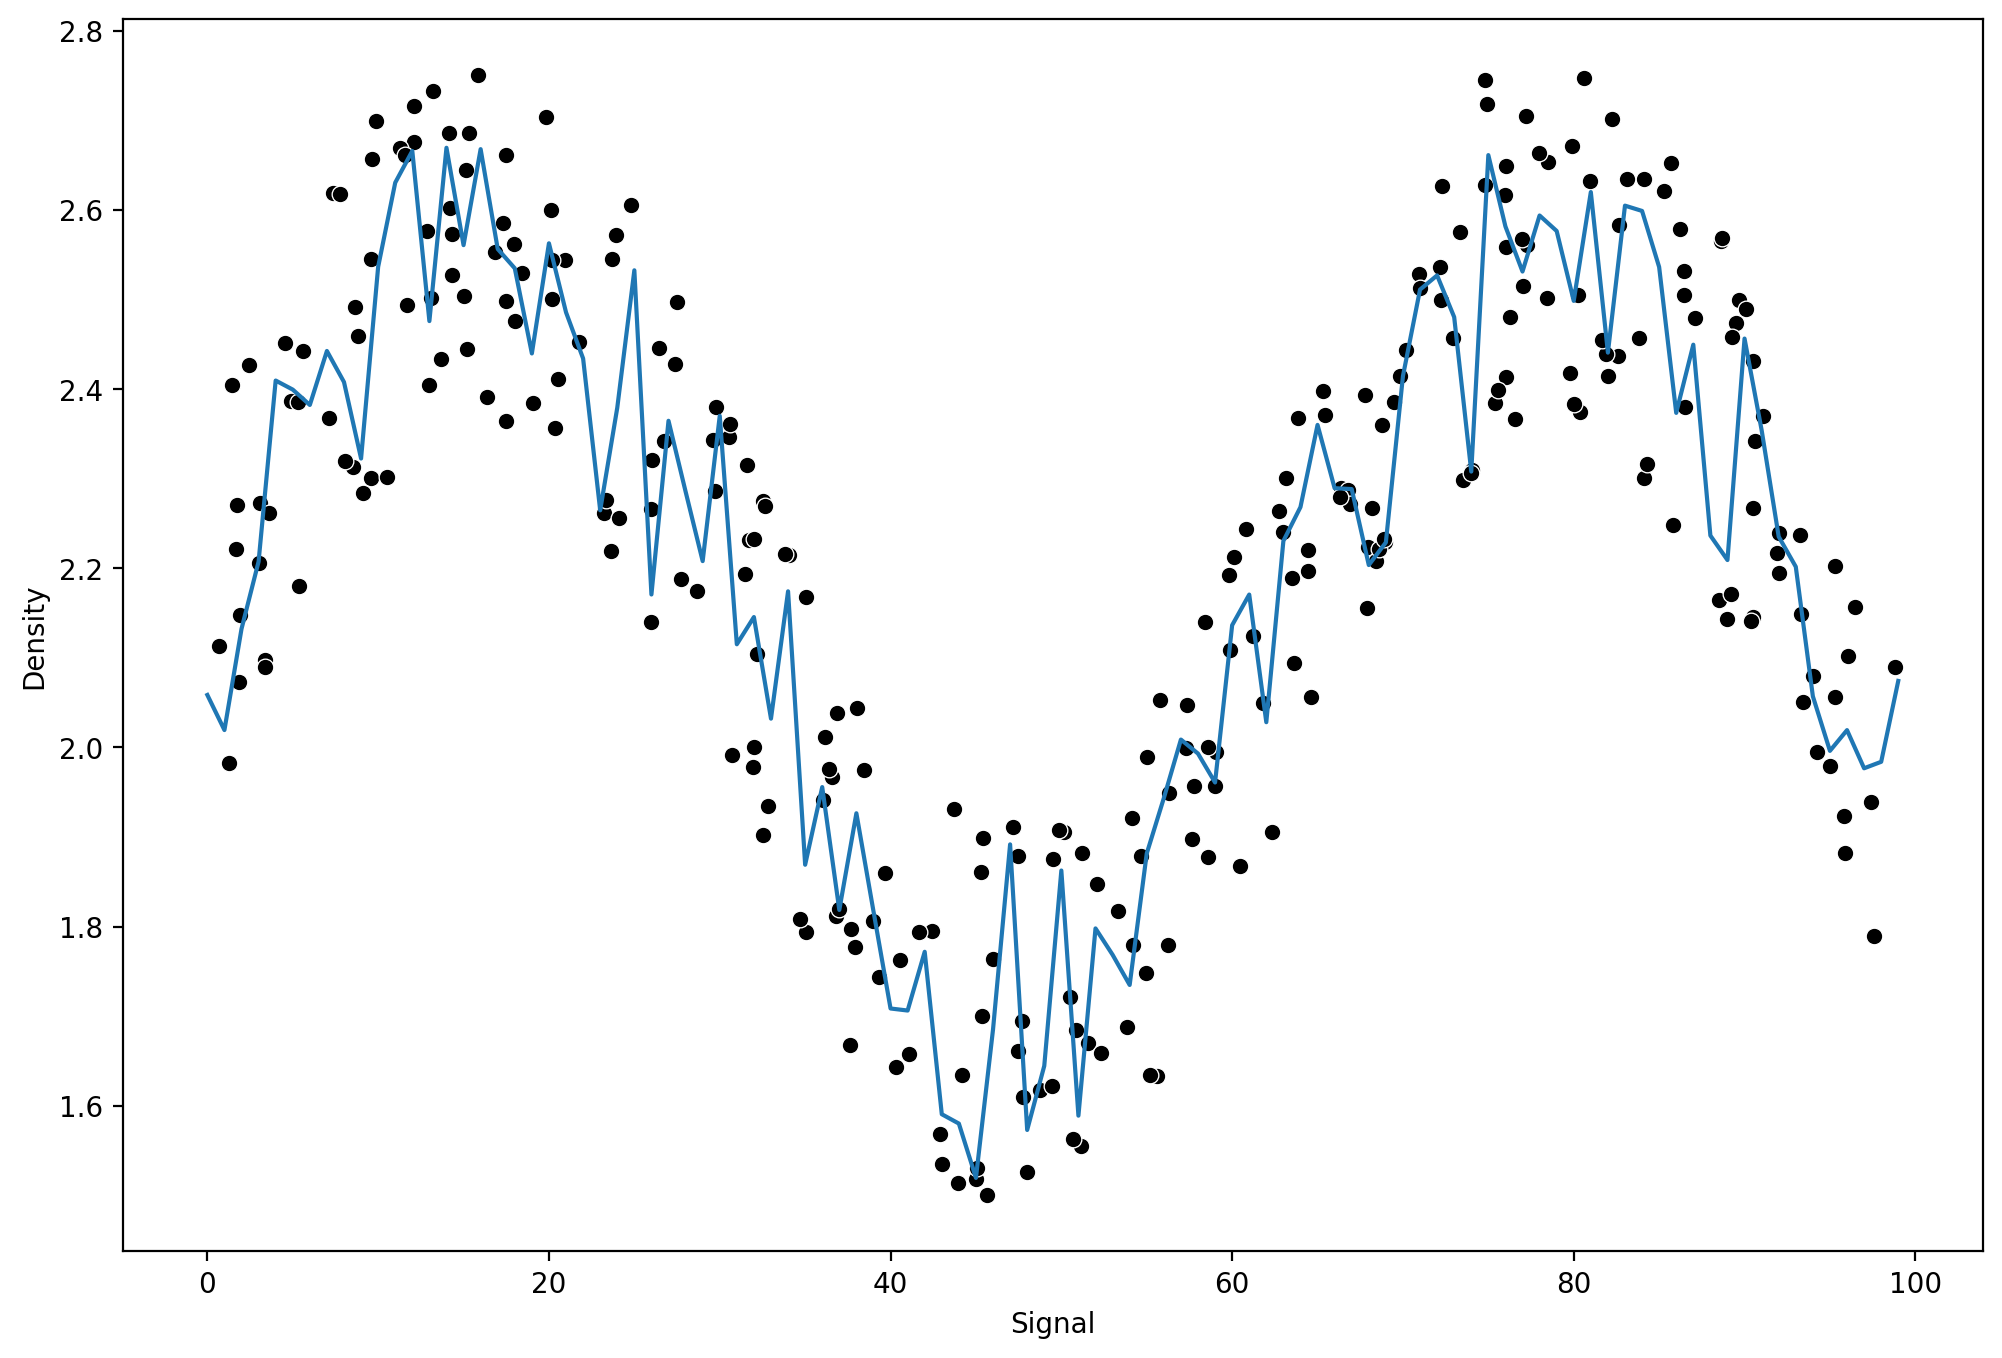

In [80]:
run_model(rfr, X_train, y_train, X_test, y_test)

Мы видим, что модель достаточно чувствительна к шумам 

Запустим данную модель как расширяемые деревья (boosted trees)

In [81]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

In [82]:
gbr = GradientBoostingRegressor()

MAE: 0.11318284854800689
RMSE: 0.13294148649584667


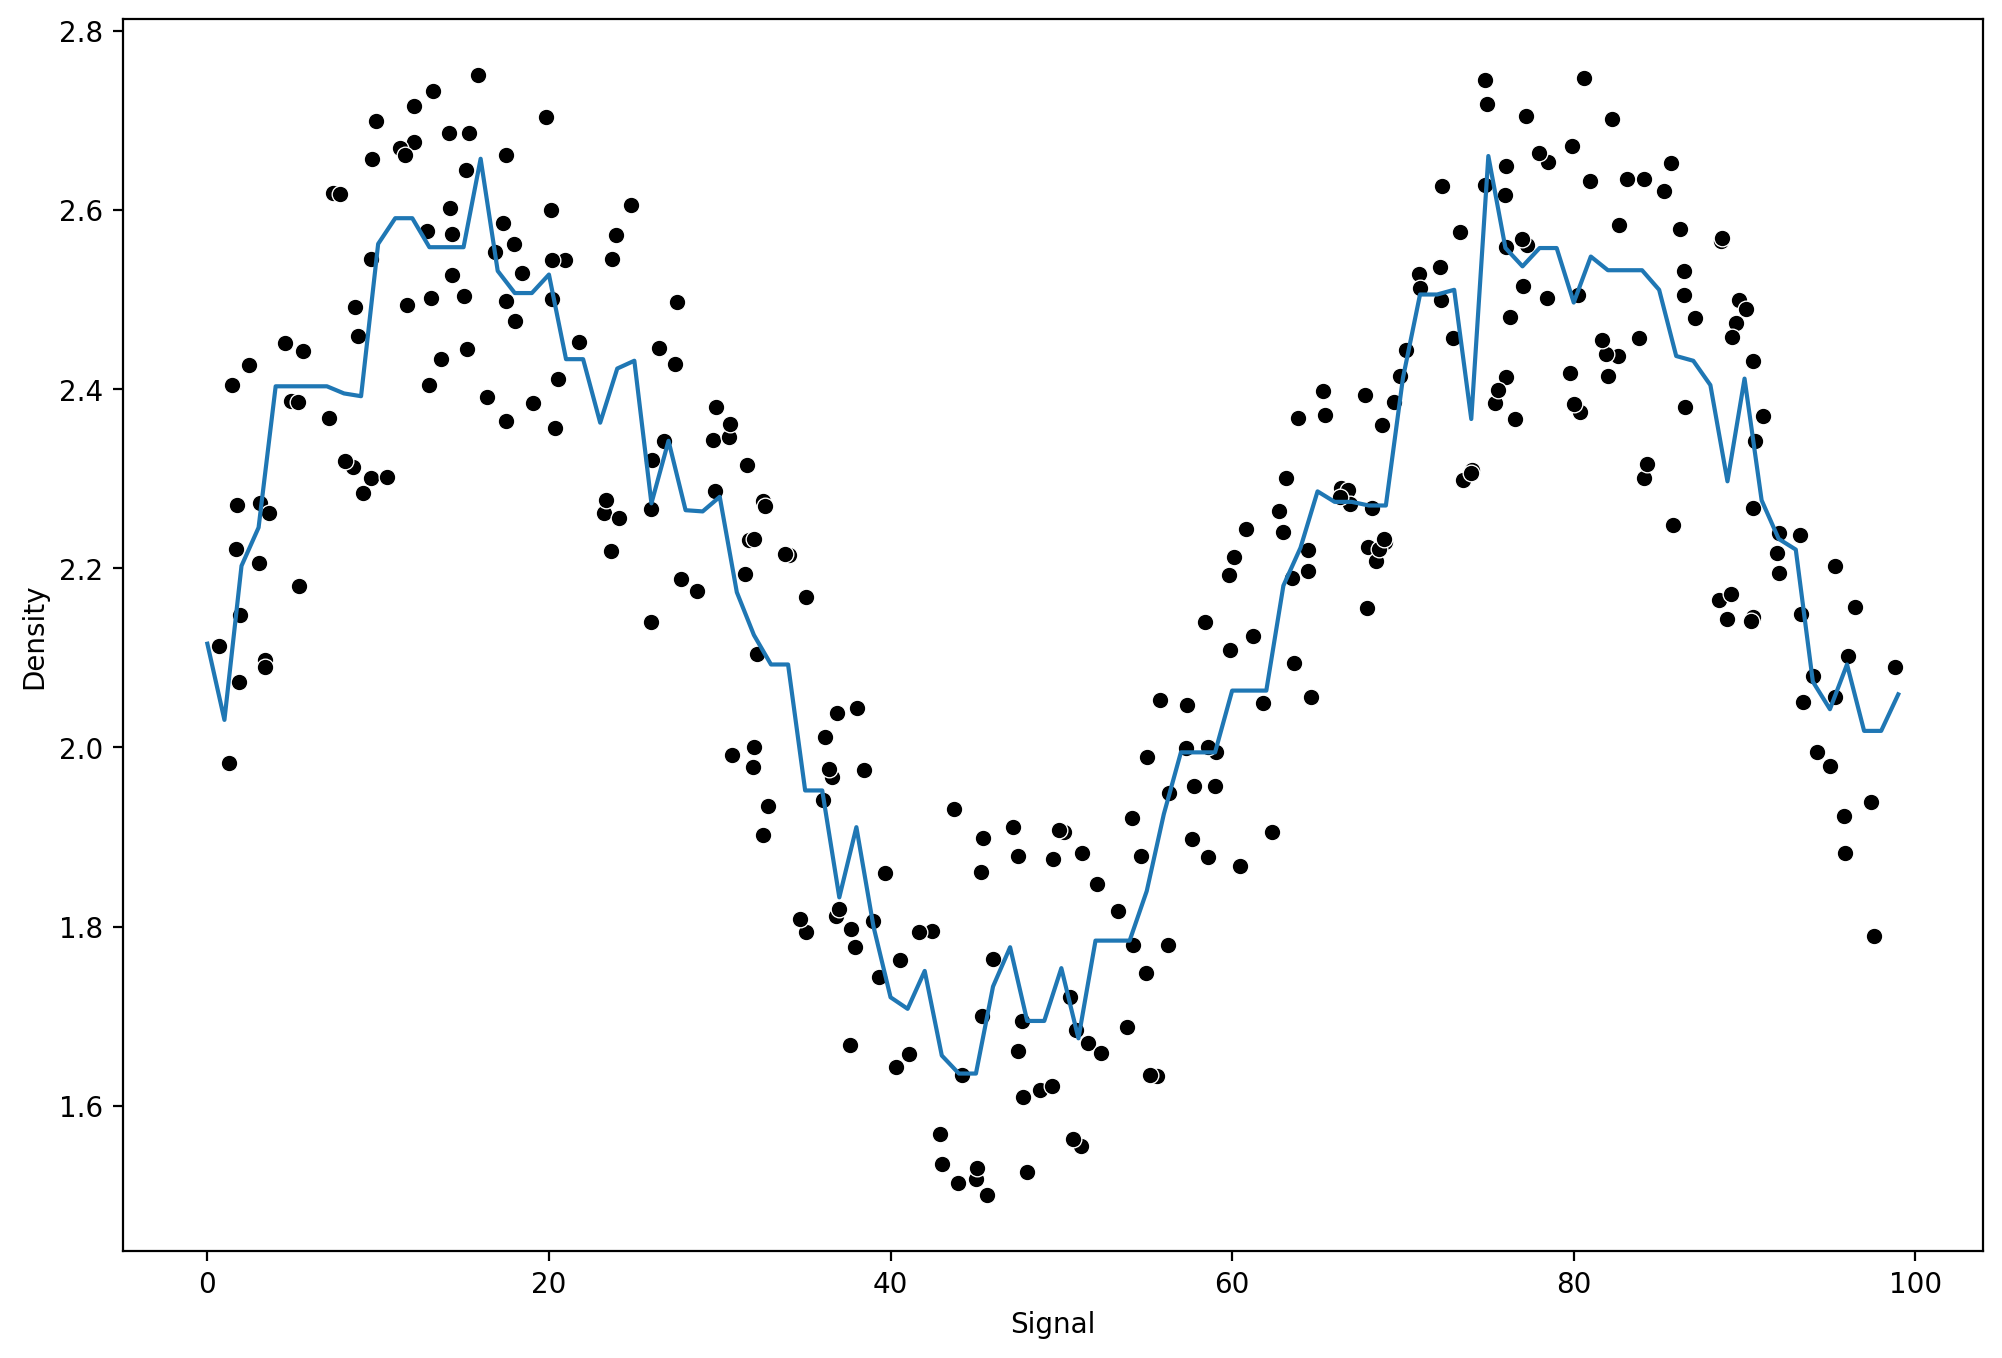

In [83]:
run_model(gbr, X_train, y_train, X_test, y_test)

график получается немного зубчатым, похожим на случайные леса и ближайших соседей. При этот график достаточно хорошо проходит вдоль общего тренда наших точек. В данной задаче градиентный бустинг работает лучше, чем случайный лес с n_estimators=10.

In [84]:
ada_br = AdaBoostRegressor()

MAE: 0.11909509122967289
RMSE: 0.13739492251371183


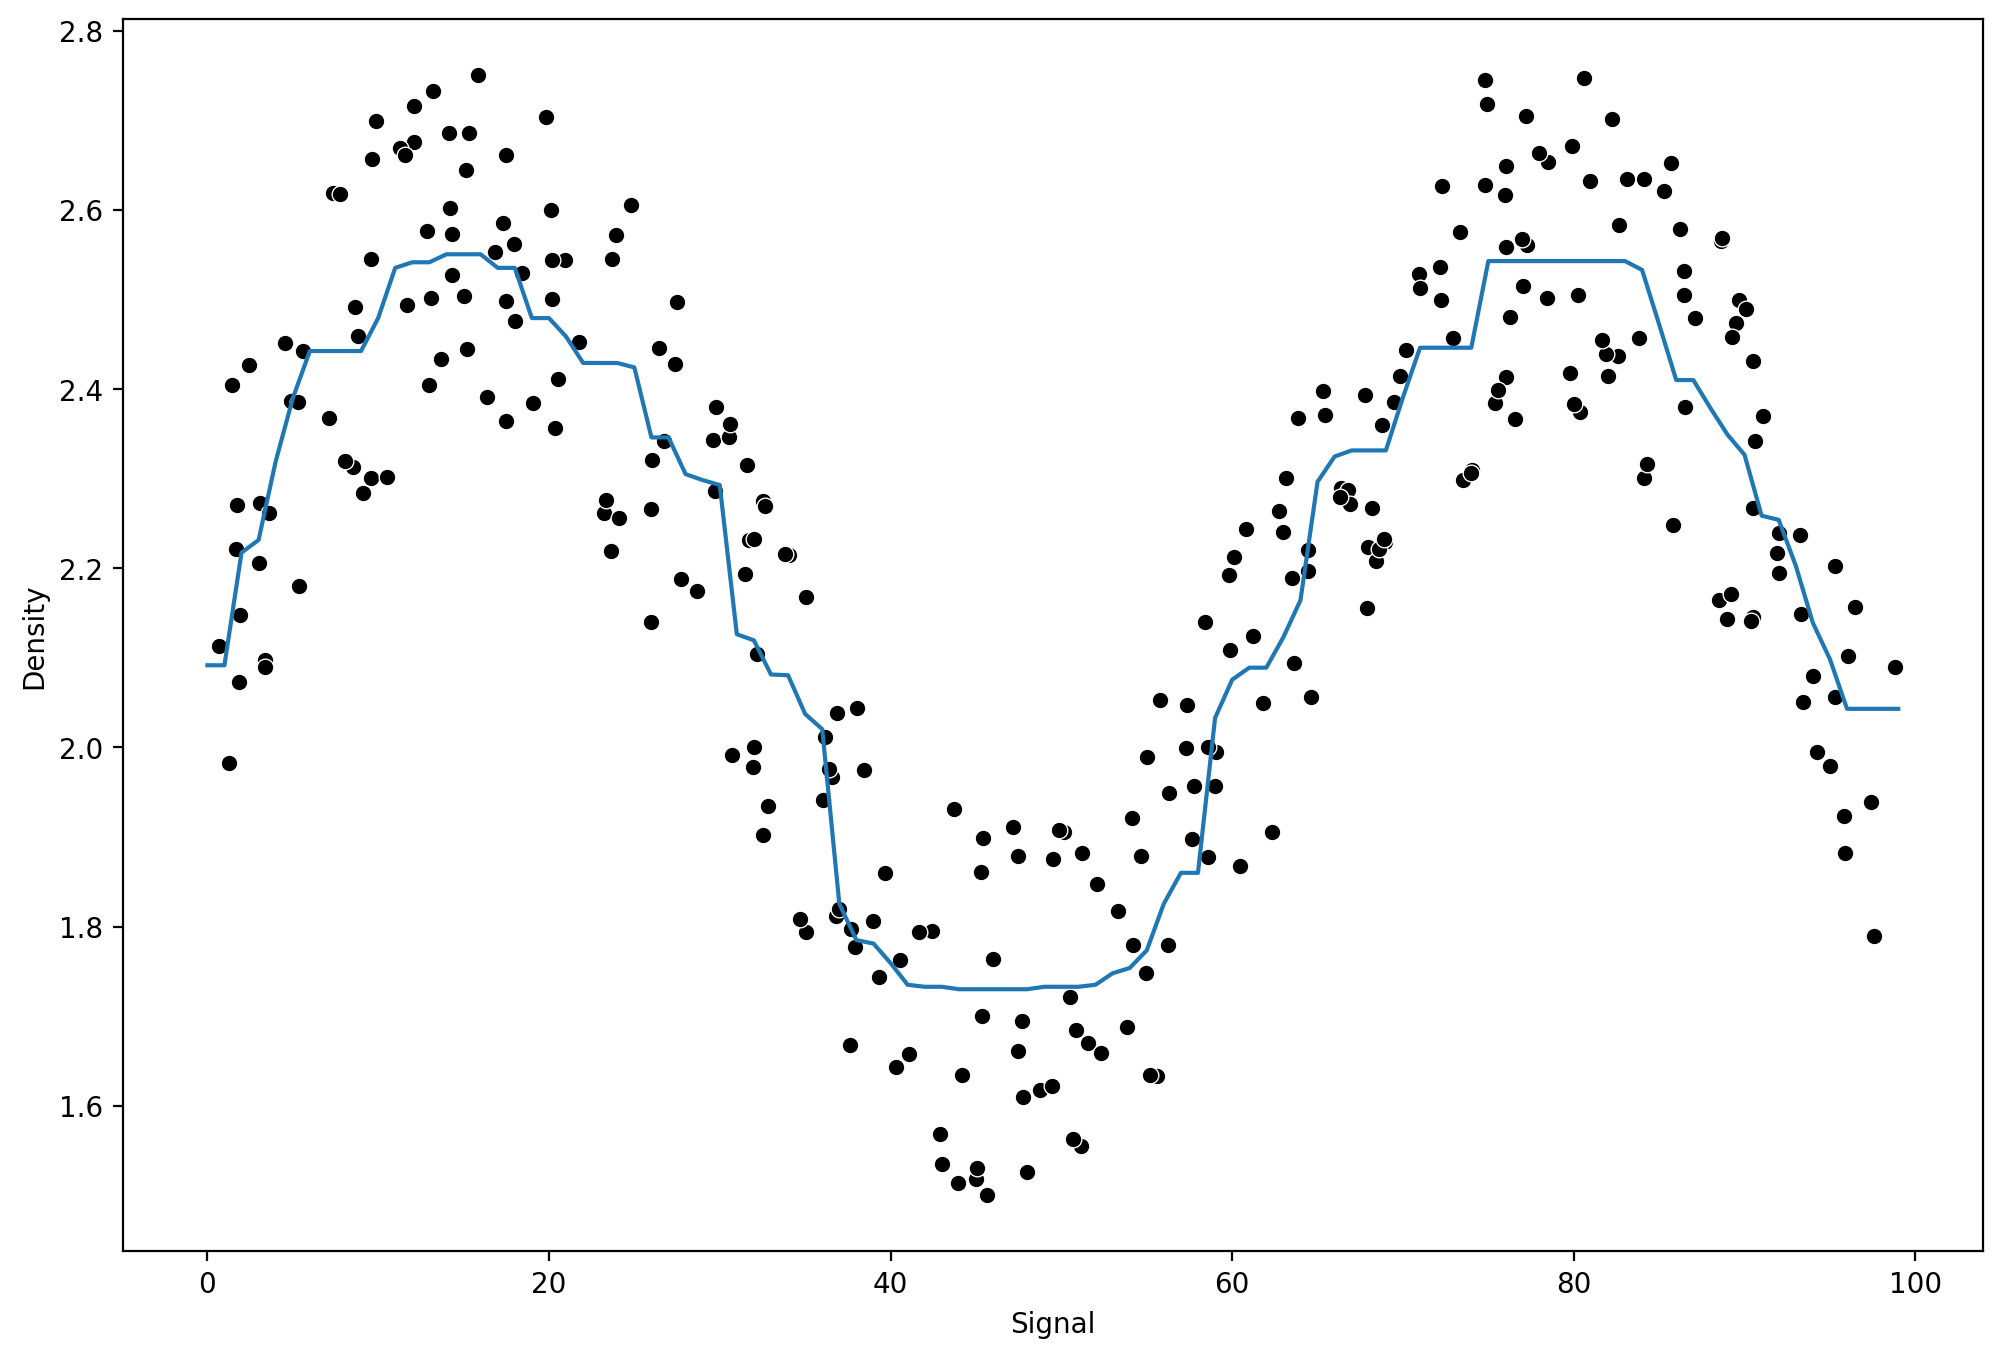

In [85]:
run_model(ada_br, X_train, y_train, X_test, y_test)

Мы видим, что эта модель не очень сильно учитывает слишком низкие и слишком высокие точки на нашем графике. 

Мы выберем модель для данной задачи по графику и значением срдней абсолютной ошибке и средней квадратичной ошибке. 

Наша финальная модель - это SVR

In [89]:
final_model_svr = SVR(C=1000, gamma='scale')